In [ ]:
# 김민솔
# 간편식 수요 예측 및 공정 최적화를 통한 생산 효율 향상 프로젝트
# 2022.12.4

# 데이터 확인

In [ ]:
# 폰트
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

설치 후 런타임 재시작 해줘야 폰트가 설정 됩니다.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rcParams['font.family']='NanumGothic'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 데이터 불러오기
import pandas as pd

cooking = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/알파코/파이썬 프로젝트/Project2/Cooking_data_set.csv')
error = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/알파코/파이썬 프로젝트/Project2/Error_Message.csv')
booking = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/알파코/파이썬 프로젝트/Project2/booking_data.csv', low_memory=False)
product = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/알파코/파이썬 프로젝트/Project2/Product_Name.csv', low_memory=False)

In [ ]:
cooking.head(3)

In [ ]:
error.head(3)

In [ ]:
booking.head(3)

In [ ]:
product.head(3)

In [ ]:
# 앞자리만 다른 코드가 존재
product[product['품목코드'].str.contains('6B04003', na=False)]

In [ ]:
# (재)만 붙은걸까?
product[product['품목코드'].str.contains('3D02277', na=False)]

## 앞자리가 1과 2인 데이터 비교

In [ ]:
# 서브셋 생성
product_s = product[['품목코드','품목명']].copy()
cooking_s = cooking[['품목코드','품목명']].copy()

In [ ]:
# 1과 2 나누기
product_s_1 = product_s[product_s['품목코드'].str.startswith('1')==True]
print(len(product_s_1))

# 중복제거
product_s_1_d =  product_s_1.drop_duplicates(subset=['품목코드'], keep='first', ignore_index=False)
print(len(product_s_1_d))

product_s_2 = product_s[product_s['품목코드'].str.startswith('2')==True]
print(len(product_s_2))

product_s_2_d = product_s_2.drop_duplicates(subset=['품목코드'], keep='first', ignore_index=False)
print(len(product_s_2_d))

1345
1345
1490
1490


In [ ]:
# 1인 데이터 품목명에 (재) 추가하기
product_s_1_d['재추가']= product_s_1_d['품목명'].apply(lambda x: str(x)+'(재)')

In [ ]:
# 2인 데이터를 1로 변경한 컬럼 생성
product_s_2_d['품목코드_통일'] = product_s['품목코드'].str.slice(start=1)
product_s_2_d['품목코드_통일'] = '1'+product_s_2_d['품목코드_통일']

In [ ]:
# 2인 데이터의 품목코드_통일 컬럼 기준으로 합치기
product_s_2_d_merge = product_s_2_d.merge(product_s_1_d, how= 'left', left_on = '품목코드_통일', right_on = '품목코드')
product_s_2_d_merge

,품목코드_x,품목명_x,품목코드_통일,품목코드_y,품목명_y,재추가
0,20000001,시생산(재),10000001,NaN,NaN,NaN
1,21501101,조미액-햄야채볶음밥(재),11501101,NaN,NaN,NaN
2,21501104,조미액-게살볶음밥(재),11501104,NaN,NaN,NaN
3,21501106,조미액-새우볶음밥(재),11501106,NaN,NaN,NaN
4,21501108,조미액-해물볶음밥(재),11501108,NaN,NaN,NaN
...,...,...,...,...,...,...
1485,2BA03596,갈릭시즐링라이스 3kg(재),1BA03596,1BA03596,갈릭시즐링라이스 3kg,갈릭시즐링라이스 3kg(재)
1486,2BA04003,카모메냉동우동면8각/반개면(재),1BA04003,NaN,NaN,NaN
1487,2C301013,고소쌈장(튜브)(재),1C301013,1C301013,고소쌈장(튜브),고소쌈장(튜브)(재)
1488,2D001002,모노치즈허니월넛크림치즈(재),1D001002,NaN,NaN,NaN


In [ ]:
# null 값은 2에는 있고 1에는 없는 경우이다.
#  - 새로생긴 품목
product_s_2_d_merge.isnull().sum()

품목코드_x       0
품목명_x        4
품목코드_통일      0
품목코드_y     683
품목명_y      684
재추가        683
dtype: int64

In [ ]:
# null 아닌 애들이 서로 같은지 비교 하면된다.
## 아닌 애들만 추출
product_s_2_d_merge_drop = product_s_2_d_merge.dropna(axis=0)

In [ ]:
# 원래 2인 데이터들의 품목명 중복제거
product_s_2_d_merge_drop_name1 = set(product_s_2_d_merge_drop['품목명_x'])

In [ ]:
# 원래 1인 데이터들의 품목명 + (재)
product_s_2_d_merge_drop_name2 = set(product_s_2_d_merge_drop['재추가'])

In [ ]:
# 원래2었던 데이터의 품목명 - 1+(재)한 품목명
origin_2 = list(product_s_2_d_merge_drop_name1 - product_s_2_d_merge_drop_name2)

In [ ]:
# 1+(재) - 원래2
origin_1 = list(product_s_2_d_merge_drop_name2 - product_s_2_d_merge_drop_name1)

In [ ]:
# 원래2었던 데이터의 품목명 - 1+(재)한 품목명 데이터 프레임 만들기
compare_df1 = pd.DataFrame()
compare_df2 = pd.DataFrame()
code_df1 = pd.DataFrame()
code_df2 = pd.DataFrame()


compare_df1['원래2'] = origin_2
code_df1 = product_s_2_d_merge_drop[['품목코드_통일','품목명_x']].copy()
compare_df1 = compare_df1.merge(code_df1, how='left', left_on='원래2', right_on='품목명_x')
compare_df1 = compare_df1.drop('품목명_x', axis=1)
compare_df1

In [ ]:
# 1+(재)한 품목명 - 원래2었던 데이터의 품목명 데이터 프레임 만들기
compare_df2['원래1+재'] = origin_1
code_df2 = product_s_2_d_merge_drop[['품목코드_통일','재추가']].copy()
compare_df2 = compare_df2.merge(code_df2, how='left', left_on='원래1+재', right_on='재추가')
compare_df2 = compare_df2.drop('재추가', axis=1)

In [ ]:
# 비교해보니 1과2가 다른 상품들은 전부 (재)만 추가한 것이거나 상품명만 조금 달라진 경우이다.
compare_df1.merge(compare_df2, on = '품목코드_통일')

# 데이터 전처리

## 앞자리 통일
* 앞자리만 다른 품목명은 상품은 같기때문에 앞자리를 1로 통일 시킨다.

In [ ]:
# 필요한 컬럼만 서브셋
product_c = product[['품목코드','품목명']].copy()
product_c.dropna(subset=['품목코드'], inplace=True)
cooking_c = cooking.copy()
cooking_c.dropna(subset=['품목코드'], inplace=True)

In [ ]:
# 품목코드에 특수문자 있는 데이터 삭제
product_c = product_c[product_c['품목코드'].str.isalnum()]
cooking_c = cooking_c[cooking_c['품목코드'].str.isalnum()]

In [ ]:
# 앞자리 1로 통일
product_c['품목코드_통일'] = product['품목코드'].str.slice(start=1)
product_c['품목코드_통일'] = '1'+product_c['품목코드_통일']

cooking_c['품목코드_통일'] = cooking_c['품목코드'].str.slice(start=1)
cooking_c['품목코드_통일'] = '1'+cooking_c['품목코드_통일']

In [ ]:
# 품목명에 결측치 있는 행 제거
product_c.dropna(subset=['품목명'], inplace=True)
cooking_c.dropna(subset=['품목명'], inplace=True)

In [ ]:
# 인덱스 정리
product_c.reset_index(inplace=True)
cooking_c.reset_index(inplace=True)

In [ ]:
# 컬럼 정리
product_c.drop('index', axis=1, inplace=True)
cooking_c.drop('index', axis=1, inplace=True)

## 2019년도 이후 데이터만 추출
* 코로나 이후 데이터만 살펴보기 위해 데이터를 자른다.

In [ ]:
booking_c = booking.copy()

In [ ]:
# 결측치 제거
booking_c.dropna(subset=['수주일자'], inplace=True)

In [ ]:
# 수주일자 문자열로 형변환
booking_c['수주일자'] = booking_c['수주일자'].astype('str')

In [ ]:
# booking의 2019년도 데이터
booking_c = booking_c[booking_c['수주일자'].str.slice(start=0, stop=4).apply(lambda x: int(x)) > 2018].copy()

In [ ]:
# 결측치 제거
cooking_c.dropna(subset=['생산일자'], inplace=True)

In [ ]:
# cooking_c 2019년도 데이터
cooking_c = cooking_c[cooking_c['생산일자'].str.slice(start=0, stop=4).apply(lambda x: int(x)) > 2018].copy()

## booking, cooking, product 머지

In [ ]:
# 필요한 컬럼만 뽑아서 booking 서브셋 생성
booking_c = booking_c[['수주부서','수주일자','수주품목코드','출고수량KG', '수주수량KG', '출하완료여부', '생산지시','납기일자']].copy()

In [ ]:
# product 와 booking 머지
product_booking = product_c.merge(booking_c, how='inner', left_on='품목코드_통일', right_on='수주품목코드')
product_booking

,품목코드,품목명,품목코드_통일,수주부서,수주일자,수주품목코드,출고수량KG,수주수량KG,출하완료여부,생산지시,납기일자
0,11501135,한식베이스소스2kg,11501135,400,20200525,11501135,600.0,600.0,Y,NaN,20200602
1,11501135,한식베이스소스2kg,11501135,400,20210406,11501135,600.0,600.0,Y,NaN,20210426
2,11501135,한식베이스소스2kg,11501135,400,20201229,11501135,600.0,600.0,Y,NaN,20210107
3,11501135,한식베이스소스2kg,11501135,400,20210108,11501135,204.0,204.0,Y,NaN,20210113
4,11501135,한식베이스소스2kg,11501135,400,20190221,11501135,48.0,48.0,Y,NaN,20190225
...,...,...,...,...,...,...,...,...,...,...,...
659548,2BA02030,양송이포테이토크림생수프(재),1BA02030,400,20191030,1BA02030,135.2,135.2,Y,NaN,20191101
659549,2BA02030,양송이포테이토크림생수프(재),1BA02030,400,20191130,1BA02030,135.2,135.2,Y,N,20191201
659550,2BA02030,양송이포테이토크림생수프(재),1BA02030,400,20191231,1BA02030,135.2,135.2,Y,N,20200101
659551,2BA02030,양송이포테이토크림생수프(재),1BA02030,400,20200131,1BA02030,135.2,135.2,Y,N,20200201


In [ ]:
# 결측치 제거
product_booking.dropna(subset=['품목코드_통일','수주수량KG'], inplace=True)

In [ ]:
# 중복 컬럼 제거
product_booking.drop('수주품목코드',axis=1,inplace=True)

In [ ]:
# 필요한 컬럼만 뽑아서 cooking 서브셋 생성
cooking_c = cooking_c[['생산라인코드','생산일자','품목코드_통일', '작업장코드','충전실온도','실링온도','쿠킹온도','쿠킹스팀압력','실링압력' ,'생산시간']]

In [ ]:
# product_booking 와 cooking 머지
product_booking_cooking = product_booking.merge(cooking_c, how='inner', left_on='품목코드_통일' , right_on='품목코드_통일')

In [ ]:
# 결측치 제거
product_booking_cooking.dropna(subset=['품목코드_통일','수주수량KG'], inplace=True)

In [ ]:
# 중복 컬럼 제거
product_booking_cooking.drop('품목코드', axis=1, inplace=True)

## 전체 데이터 이상치 제거

In [ ]:
# 품목 코드 리스트
code_list = product_booking_cooking['품목코드_통일'].unique()
len(code_list)

777

In [ ]:
# product_booking_cooking 이상치 삭제 함수
def no_ideal(x):
    df=product_booking_cooking[product_booking_cooking['품목코드_통일']==str(x)]
    q =df.quantile([.25,.75])
    q1 = q.iloc[0,2]
    q2 = q.iloc[1,2]
    i = q2-q1
    i1 = q1 - 1.5*i
    i2 = q2 + 1.5*i 
    df = df[(df['수주수량KG']>i1) & (df['수주수량KG']<i2)]
    return df

In [ ]:
# 코드 리스트에 함수 적용 - product_booking_cooking 이상치 삭제
import time
from tqdm import tqdm

product_booking_cooking_no_ideal = pd.DataFrame()
for c in tqdm(code_list):
    product_booking_cooking_no_ideal = pd.concat([product_booking_cooking_no_ideal,no_ideal(c)])

100%|██████████| 777/777 [07:38<00:00,  1.69it/s]


In [ ]:
len(product_booking_cooking_no_ideal)

93982

In [ ]:
# csv로 저장
product_booking_cooking_no_ideal.to_csv('/content/drive/MyDrive/Colab Notebooks/알파코/파이썬 프로젝트/Project2/product_booking_cooking_no_ideal.csv')

In [ ]:
# # 불러오는 코드
# import pandas as pd
# product_booking_cooking_no_ideal = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/알파코/파이썬 프로젝트/Project2/product_booking_cooking_no_ideal.csv',low_memory=False)

In [ ]:
# # 불러왔을 때 컬럼 정리
# product_booking_cooking_no_ideal.drop('Unnamed: 0', axis=1, inplace=True)

## 품목코드별 날짜 컬럼 형변환 하고 연월 컬럼 생성

In [ ]:
product_booking_cooking_no_ideal.tail(3)

,품목명,품목코드_통일,수주부서,수주일자,출고수량KG,수주수량KG,출하완료여부,생산지시,납기일자,생산라인코드,생산일자,작업장코드,충전실온도,실링온도,쿠킹온도,쿠킹스팀압력,실링압력,생산시간
7618478,슈퍼곡물귀리소고기죽(파우치)450g(재),1BA01045,202,20210326,71.55,71.55,Y,N,20210326,L001,2020-02-24,W002,71.579521,91.979521,127.749721,23.847,202.929,80.11
7618705,슈퍼곡물귀리소고기죽(파우치)450g(재),1BA01045,202,20210802,72.00,72.00,Y,N,20210801,C098,2019-11-28,W003,71.777769,103.477769,139.108819,23.754,212.910,76.88
7618706,슈퍼곡물귀리소고기죽(파우치)450g(재),1BA01045,202,20210802,72.00,72.00,Y,N,20210801,L001,2020-02-24,W002,71.579521,91.979521,127.749721,23.847,202.929,80.11


In [ ]:
# 생산일자 형변환 (문자열)
product_booking_cooking_no_ideal['생산일자_년월일'] = product_booking_cooking_no_ideal['생산일자'].astype('str')

In [ ]:
# 생산일자 확인
product_booking_cooking_no_ideal['생산일자_년월일'].sort_values(ascending = False)

5466435    2021-10-29
7541179    2021-10-29
5465859    2021-10-29
2475221    2021-10-28
2710028    2021-10-28
              ...    
2257006    2019-01-02
2256488    2019-01-02
2254822    2019-01-02
2254612    2019-01-02
2254857    2019-01-02
Name: 생산일자_년월일, Length: 93982, dtype: object

In [ ]:
# 생산일자 형변환 (데이트타임)
product_booking_cooking_no_ideal['생산일자_년월일'] = pd.to_datetime(product_booking_cooking_no_ideal['생산일자'])

In [ ]:
# 수주일자 형변환 (문자열)
product_booking_cooking_no_ideal['수주일자_년월일'] = product_booking_cooking_no_ideal['수주일자'].astype('str')

In [ ]:
# 이상치 변경
product_booking_cooking_no_ideal['수주일자_년월일']= product_booking_cooking_no_ideal['수주일자_년월일'].apply(lambda x: x.replace('21210727','20210727'))
product_booking_cooking_no_ideal

,품목명,품목코드_통일,수주부서,수주일자,출고수량KG,수주수량KG,출하완료여부,생산지시,납기일자,생산라인코드,생산일자,작업장코드,충전실온도,실링온도,쿠킹온도,쿠킹스팀압력,실링압력,생산시간,생산일자_년월일,수주일자_년월일
338,시아스떡볶이양념소스,13A00010,NaN,20210405,72.00,72.00,Y,N,20210406,P002,2019-07-30,W007,71.486206,100.386206,136.084756,23.799,210.049,73.90,2019-07-30,20210405
339,시아스떡볶이양념소스,13A00010,NaN,20210405,72.00,72.00,Y,N,20210406,C001,2020-12-16,W003,72.575330,96.475330,132.404580,23.953,210.781,76.42,2020-12-16,20210405
930,시아스떡볶이양념소스,13A00010,sc600,20200331,0.00,72.00,Y,N,20200401,P002,2019-07-30,W007,71.486206,100.386206,136.084756,23.799,210.049,73.90,2019-07-30,20200331
931,시아스떡볶이양념소스,13A00010,sc600,20200331,0.00,72.00,Y,N,20200401,C001,2020-12-16,W003,72.575330,96.475330,132.404580,23.953,210.781,76.42,2020-12-16,20200331
1008,시아스떡볶이양념소스,13A00010,200,20190123,72.00,72.00,Y,N,20190124,P002,2019-07-30,W007,71.486206,100.386206,136.084756,23.799,210.049,73.90,2019-07-30,20190123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7617680,슈퍼곡물귀리소고기죽(파우치)450g(재),1BA01045,202,20191230,71.55,71.55,Y,N,20191229,L001,2020-02-24,W002,71.579521,91.979521,127.749721,23.847,202.929,80.11,2020-02-24,20191230
7618477,슈퍼곡물귀리소고기죽(파우치)450g(재),1BA01045,202,20210326,71.55,71.55,Y,N,20210326,C098,2019-11-28,W003,71.777769,103.477769,139.108819,23.754,212.910,76.88,2019-11-28,20210326
7618478,슈퍼곡물귀리소고기죽(파우치)450g(재),1BA01045,202,20210326,71.55,71.55,Y,N,20210326,L001,2020-02-24,W002,71.579521,91.979521,127.749721,23.847,202.929,80.11,2020-02-24,20210326
7618705,슈퍼곡물귀리소고기죽(파우치)450g(재),1BA01045,202,20210802,72.00,72.00,Y,N,20210801,C098,2019-11-28,W003,71.777769,103.477769,139.108819,23.754,212.910,76.88,2019-11-28,20210802


In [ ]:
# 수주일자 확인
product_booking_cooking_no_ideal['수주일자_년월일'].sort_values(ascending = False)

1181864    20211102
1181871    20211102
1181860    20211102
1181861    20211102
1181862    20211102
             ...   
766250     20190101
766249     20190101
766248     20190101
769206     20190101
769207     20190101
Name: 수주일자_년월일, Length: 93982, dtype: object

In [ ]:
# 수주일자 형변환 (데이트타임)
product_booking_cooking_no_ideal['수주일자_년월일'] = pd.to_datetime(product_booking_cooking_no_ideal['수주일자_년월일'])

In [ ]:
# 결측치 확인
product_booking_cooking_no_ideal.isnull().sum()

품목명             0
품목코드_통일         0
수주부서        15386
수주일자            0
출고수량KG          0
수주수량KG          0
출하완료여부          0
생산지시         3675
납기일자            0
생산라인코드          0
생산일자            0
작업장코드           0
충전실온도           0
실링온도            0
쿠킹온도            0
쿠킹스팀압력          0
실링압력            0
생산시간         3877
생산일자_년월일        0
수주일자_년월일        0
dtype: int64

In [ ]:
# 수주일자 연월만 생성
product_booking_cooking_no_ideal['수주일자_년월'] = product_booking_cooking_no_ideal['수주일자_년월일'].astype('str')
product_booking_cooking_no_ideal['수주일자_년월'] = product_booking_cooking_no_ideal['수주일자_년월'].apply(lambda x: x.split('-')[0]+x.split('-')[1])

In [ ]:
# 생산일자 연월만 생성
product_booking_cooking_no_ideal['생산일자_년월'] = product_booking_cooking_no_ideal['생산일자'].astype('str')
product_booking_cooking_no_ideal['생산일자_년월'] = product_booking_cooking_no_ideal['생산일자_년월'].apply(lambda x: x.split('-')[0]+x.split('-')[1])

## 최근 한달 데이터 삭제
* 최근 한달은 데이터가 전부 모이지 않았기 때문에 삭제해준다.

In [ ]:
# 최근 한달 데이터 인덱스 추출
index =product_booking_cooking_no_ideal[product_booking_cooking_no_ideal['수주일자_년월']=='202111'].index
index

Int64Index([ 267895,  267896,  267897,  267898,  267899,  267900,  267901,
             267902,  764175,  764176,
            ...
            6720812, 6720813, 6720814, 6720815, 6720816, 6720817, 6720818,
            6720819, 6720820, 6720821],
           dtype='int64', length=161)

In [ ]:
# 해당 인덱스 삭제
product_booking_cooking_no_ideal = product_booking_cooking_no_ideal.drop(index, axis=0).copy()

In [ ]:
# 확인
product_booking_cooking_no_ideal.sort_values(by='수주일자_년월', ascending=False)

,품목명,품목코드_통일,수주부서,수주일자,출고수량KG,수주수량KG,출하완료여부,생산지시,납기일자,생산라인코드,...,실링온도,쿠킹온도,쿠킹스팀압력,실링압력,생산시간,생산일자_년월일,수주일자_년월일,수주일자_년월,생산일자_년월,출하완료여부_num
1158389,발사믹올리브유드레싱110g(재),13D02308,202,20211015,70.73,70.73,Y,N,20211015,C045,...,104.570728,139.949628,23.586,210.688,74.74,2020-08-27,2021-10-15,202110,202008,1
1706728,노브랜드돈까스소스(재),13R04036,202,20211027,70.95,70.95,Y,N,20211027,D006,...,87.573458,123.435058,23.908,209.186,76.98,2020-03-18,2021-10-27,202110,202003,1
1706694,노브랜드돈까스소스(재),13R04036,202,20211026,70.95,70.95,Y,N,20211027,P006,...,109.286559,145.491359,24.137,207.768,79.97,2020-03-18,2021-10-26,202110,202003,1
1706695,노브랜드돈까스소스(재),13R04036,202,20211026,70.95,70.95,Y,N,20211027,P006,...,90.539401,126.615801,24.051,205.910,80.50,2020-03-24,2021-10-26,202110,202003,1
1706696,노브랜드돈까스소스(재),13R04036,202,20211026,70.95,70.95,Y,N,20211027,C003,...,95.671799,131.440549,23.846,209.360,76.83,2020-07-27,2021-10-26,202110,202007,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6127139,NEW햄야채볶음밥300g,1BA03249,200,20190103,72.00,72.00,Y,N,20190104,D088,...,105.503316,141.787716,24.190,212.288,79.66,2020-12-16,2019-01-03,201901,202012,1
6127140,NEW햄야채볶음밥300g,1BA03249,200,20190103,72.00,72.00,Y,N,20190104,D088,...,103.019359,137.497359,22.985,201.330,NaN,2021-05-26,2019-01-03,201901,202105,1
6127141,NEW햄야채볶음밥300g,1BA03249,200,20190103,72.00,72.00,Y,N,20190104,D088,...,96.443572,130.898472,22.970,204.783,NaN,2021-05-26,2019-01-03,201901,202105,1
6127142,NEW햄야채볶음밥300g,1BA03249,200,20190103,72.00,72.00,Y,N,20190104,D088,...,96.518624,132.138224,23.746,208.153,76.27,2021-06-29,2019-01-03,201901,202106,1


## 출고여부 수치형 컬럼 생성

In [ ]:
def replace_num(x):
    if x == 'Y':
        return 1
    else:
        return 0

In [ ]:
# 출하여부 수치형으로 변경
product_booking_cooking_no_ideal['출하완료여부_num'] = product_booking_cooking_no_ideal['출하완료여부'].apply(lambda x: replace_num(x))

## 제품군별 세브셋 생성

In [ ]:
# 제품군 나누기 (소스, 밥, 마요네즈, 드레싱, 샐러드, 기타)
# 소스
product_booking_cooking_no_ideal_source = product_booking_cooking_no_ideal[product_booking_cooking_no_ideal['품목명'].str.contains('소스')]
product_booking_cooking_no_ideal_source_index = product_booking_cooking_no_ideal[product_booking_cooking_no_ideal['품목명'].str.contains('소스')].index
product_booking_cooking_no_ideal_no_source = product_booking_cooking_no_ideal.drop(product_booking_cooking_no_ideal_source_index).copy()

# 밥
product_booking_cooking_no_ideal_bob = product_booking_cooking_no_ideal_no_source[(product_booking_cooking_no_ideal_no_source['품목명'].str.contains('밥'))]
product_booking_cooking_no_ideal_bob_index = product_booking_cooking_no_ideal_no_source[(product_booking_cooking_no_ideal_no_source['품목명'].str.contains('밥'))].index
product_booking_cooking_no_ideal_no_source_bob = product_booking_cooking_no_ideal_no_source.drop(product_booking_cooking_no_ideal_bob_index).copy()

# 마요네즈
product_booking_cooking_no_ideal_mayo = product_booking_cooking_no_ideal_no_source_bob[product_booking_cooking_no_ideal_no_source_bob['품목명'].str.contains('마요네즈')]
product_booking_cooking_no_ideal_mayo_index = product_booking_cooking_no_ideal_no_source_bob[product_booking_cooking_no_ideal_no_source_bob['품목명'].str.contains('마요네즈')].index
product_booking_cooking_no_ideal_no_source_bob_mayo = product_booking_cooking_no_ideal_no_source_bob.drop(product_booking_cooking_no_ideal_mayo_index).copy()

# 드레싱
product_booking_cooking_no_ideal_dress= product_booking_cooking_no_ideal_no_source_bob_mayo[product_booking_cooking_no_ideal_no_source_bob_mayo['품목명'].str.contains('드레싱')]
product_booking_cooking_no_ideal_dress_index =  product_booking_cooking_no_ideal_no_source_bob_mayo[product_booking_cooking_no_ideal_no_source_bob_mayo['품목명'].str.contains('드레싱')].index
product_booking_cooking_no_ideal_no_source_bob_mayo_dress = product_booking_cooking_no_ideal_no_source_bob_mayo.drop(product_booking_cooking_no_ideal_dress_index).copy()

# 샐러드
product_booking_cooking_no_ideal_salad= product_booking_cooking_no_ideal_no_source_bob_mayo_dress[product_booking_cooking_no_ideal_no_source_bob_mayo_dress['품목명'].str.contains('샐러드')]
product_booking_cooking_no_ideal_salad_index = product_booking_cooking_no_ideal_no_source_bob_mayo_dress[product_booking_cooking_no_ideal_no_source_bob_mayo_dress['품목명'].str.contains('샐러드')].index

# 기타
product_booking_cooking_no_ideal_etc = product_booking_cooking_no_ideal_no_source_bob_mayo_dress.drop(product_booking_cooking_no_ideal_salad_index).copy()

## 작업장 별 제품군 서브셋 생성

In [ ]:
product_booking_cooking_no_ideal_W007 = product_booking_cooking_no_ideal[product_booking_cooking_no_ideal['작업장코드']=='W007']
product_booking_cooking_no_ideal_W003 = product_booking_cooking_no_ideal[product_booking_cooking_no_ideal['작업장코드']=='W003']
product_booking_cooking_no_ideal_W005 = product_booking_cooking_no_ideal[product_booking_cooking_no_ideal['작업장코드']=='W005']
product_booking_cooking_no_ideal_W002 = product_booking_cooking_no_ideal[product_booking_cooking_no_ideal['작업장코드']=='W002']

In [ ]:
# 작업장 W007 분류
product_booking_cooking_no_ideal_W007_source = product_booking_cooking_no_ideal_W007[product_booking_cooking_no_ideal_W007['품목명'].str.contains('소스')]
product_booking_cooking_no_ideal_W007_source_index = product_booking_cooking_no_ideal_W007[product_booking_cooking_no_ideal_W007['품목명'].str.contains('소스')].index
product_booking_cooking_no_ideal_W007_no_source = product_booking_cooking_no_ideal_W007.drop(product_booking_cooking_no_ideal_W007_source_index).copy()

product_booking_cooking_no_ideal_W007_bob = product_booking_cooking_no_ideal_W007_no_source[(product_booking_cooking_no_ideal_W007_no_source['품목명'].str.contains('밥'))]
product_booking_cooking_no_ideal_W007_bob_index = product_booking_cooking_no_ideal_W007_no_source[(product_booking_cooking_no_ideal_W007_no_source['품목명'].str.contains('밥'))].index
product_booking_cooking_no_ideal_W007_no_source_bob = product_booking_cooking_no_ideal_W007_no_source.drop(product_booking_cooking_no_ideal_W007_bob_index).copy()

product_booking_cooking_no_ideal_W007_mayo = product_booking_cooking_no_ideal_W007_no_source_bob[product_booking_cooking_no_ideal_W007_no_source_bob['품목명'].str.contains('마요네즈')]
product_booking_cooking_no_ideal_W007_mayo_index = product_booking_cooking_no_ideal_W007_no_source_bob[product_booking_cooking_no_ideal_W007_no_source_bob['품목명'].str.contains('마요네즈')].index
product_booking_cooking_no_ideal_W007_no_source_bob_mayo = product_booking_cooking_no_ideal_W007_no_source_bob.drop(product_booking_cooking_no_ideal_W007_mayo_index).copy()


product_booking_cooking_no_ideal_W007_dress= product_booking_cooking_no_ideal_W007_no_source_bob_mayo[product_booking_cooking_no_ideal_W007_no_source_bob_mayo['품목명'].str.contains('드레싱')]
product_booking_cooking_no_ideal_W007_dress_index =  product_booking_cooking_no_ideal_W007_no_source_bob_mayo[product_booking_cooking_no_ideal_W007_no_source_bob_mayo['품목명'].str.contains('드레싱')].index
product_booking_cooking_no_ideal_W007_no_source_bob_mayo_dress = product_booking_cooking_no_ideal_W007_no_source_bob_mayo.drop(product_booking_cooking_no_ideal_W007_dress_index).copy()

product_booking_cooking_no_ideal_W007_salad= product_booking_cooking_no_ideal_W007_no_source_bob_mayo_dress[product_booking_cooking_no_ideal_W007_no_source_bob_mayo_dress['품목명'].str.contains('샐러드')]
product_booking_cooking_no_ideal_W007_salad_index = product_booking_cooking_no_ideal_W007_no_source_bob_mayo_dress[product_booking_cooking_no_ideal_W007_no_source_bob_mayo_dress['품목명'].str.contains('샐러드')].index

product_booking_cooking_no_ideal_W007_etc = product_booking_cooking_no_ideal_W007_no_source_bob_mayo_dress.drop(product_booking_cooking_no_ideal_W007_salad_index).copy()

In [ ]:
# 작업장 W003 분류
product_booking_cooking_no_ideal_W003_source = product_booking_cooking_no_ideal_W003[product_booking_cooking_no_ideal_W003['품목명'].str.contains('소스')]
product_booking_cooking_no_ideal_W003_source_index = product_booking_cooking_no_ideal_W003[product_booking_cooking_no_ideal_W003['품목명'].str.contains('소스')].index
product_booking_cooking_no_ideal_W003_no_source = product_booking_cooking_no_ideal_W003.drop(product_booking_cooking_no_ideal_W003_source_index).copy()

product_booking_cooking_no_ideal_W003_bob = product_booking_cooking_no_ideal_W003_no_source[(product_booking_cooking_no_ideal_W003_no_source['품목명'].str.contains('밥'))]
product_booking_cooking_no_ideal_W003_bob_index = product_booking_cooking_no_ideal_W003_no_source[(product_booking_cooking_no_ideal_W003_no_source['품목명'].str.contains('밥'))].index
product_booking_cooking_no_ideal_W003_no_source_bob = product_booking_cooking_no_ideal_W003_no_source.drop(product_booking_cooking_no_ideal_W003_bob_index).copy()
product_booking_cooking_no_ideal_W003_mayo = product_booking_cooking_no_ideal_W003_no_source_bob[product_booking_cooking_no_ideal_W003_no_source_bob['품목명'].str.contains('마요네즈')]
product_booking_cooking_no_ideal_W003_mayo_index = product_booking_cooking_no_ideal_W003_no_source_bob[product_booking_cooking_no_ideal_W003_no_source_bob['품목명'].str.contains('마요네즈')].index
product_booking_cooking_no_ideal_W003_no_source_bob_mayo = product_booking_cooking_no_ideal_W003_no_source_bob.drop(product_booking_cooking_no_ideal_W003_mayo_index).copy()
product_booking_cooking_no_ideal_W003_dress= product_booking_cooking_no_ideal_W003_no_source_bob_mayo[product_booking_cooking_no_ideal_W003_no_source_bob_mayo['품목명'].str.contains('드레싱')]
product_booking_cooking_no_ideal_W003_dress_index =  product_booking_cooking_no_ideal_W003_no_source_bob_mayo[product_booking_cooking_no_ideal_W003_no_source_bob_mayo['품목명'].str.contains('드레싱')].index
product_booking_cooking_no_ideal_W003_no_source_bob_mayo_dress = product_booking_cooking_no_ideal_W003_no_source_bob_mayo.drop(product_booking_cooking_no_ideal_W003_dress_index).copy()
product_booking_cooking_no_ideal_W003_salad= product_booking_cooking_no_ideal_W003_no_source_bob_mayo_dress[product_booking_cooking_no_ideal_W003_no_source_bob_mayo_dress['품목명'].str.contains('샐러드')]
product_booking_cooking_no_ideal_W003_salad_index = product_booking_cooking_no_ideal_W003_no_source_bob_mayo_dress[product_booking_cooking_no_ideal_W003_no_source_bob_mayo_dress['품목명'].str.contains('샐러드')].index
product_booking_cooking_no_ideal_W003_etc = product_booking_cooking_no_ideal_W003_no_source_bob_mayo_dress.drop(product_booking_cooking_no_ideal_W003_salad_index).copy()

In [ ]:
# 작업장 W005 분류
product_booking_cooking_no_ideal_W005_source = product_booking_cooking_no_ideal_W005[product_booking_cooking_no_ideal_W005['품목명'].str.contains('소스')]
product_booking_cooking_no_ideal_W005_source_index = product_booking_cooking_no_ideal_W005[product_booking_cooking_no_ideal_W005['품목명'].str.contains('소스')].index
product_booking_cooking_no_ideal_W005_no_source = product_booking_cooking_no_ideal_W005.drop(product_booking_cooking_no_ideal_W005_source_index).copy()
product_booking_cooking_no_ideal_W005_bob = product_booking_cooking_no_ideal_W005_no_source[(product_booking_cooking_no_ideal_W005_no_source['품목명'].str.contains('밥'))]
product_booking_cooking_no_ideal_W005_bob_index = product_booking_cooking_no_ideal_W005_no_source[(product_booking_cooking_no_ideal_W005_no_source['품목명'].str.contains('밥'))].index
product_booking_cooking_no_ideal_W005_no_source_bob = product_booking_cooking_no_ideal_W005_no_source.drop(product_booking_cooking_no_ideal_W005_bob_index).copy()
product_booking_cooking_no_ideal_W005_mayo = product_booking_cooking_no_ideal_W005_no_source_bob[product_booking_cooking_no_ideal_W005_no_source_bob['품목명'].str.contains('마요네즈')]
product_booking_cooking_no_ideal_W005_mayo_index = product_booking_cooking_no_ideal_W005_no_source_bob[product_booking_cooking_no_ideal_W005_no_source_bob['품목명'].str.contains('마요네즈')].index
product_booking_cooking_no_ideal_W005_no_source_bob_mayo = product_booking_cooking_no_ideal_W005_no_source_bob.drop(product_booking_cooking_no_ideal_W005_mayo_index).copy()
product_booking_cooking_no_ideal_W005_dress= product_booking_cooking_no_ideal_W005_no_source_bob_mayo[product_booking_cooking_no_ideal_W005_no_source_bob_mayo['품목명'].str.contains('드레싱')]
product_booking_cooking_no_ideal_W005_dress_index =  product_booking_cooking_no_ideal_W005_no_source_bob_mayo[product_booking_cooking_no_ideal_W005_no_source_bob_mayo['품목명'].str.contains('드레싱')].index
product_booking_cooking_no_ideal_W005_no_source_bob_mayo_dress = product_booking_cooking_no_ideal_W005_no_source_bob_mayo.drop(product_booking_cooking_no_ideal_W005_dress_index).copy()
product_booking_cooking_no_ideal_W005_salad= product_booking_cooking_no_ideal_W005_no_source_bob_mayo_dress[product_booking_cooking_no_ideal_W005_no_source_bob_mayo_dress['품목명'].str.contains('샐러드')]
product_booking_cooking_no_ideal_W005_salad_index = product_booking_cooking_no_ideal_W005_no_source_bob_mayo_dress[product_booking_cooking_no_ideal_W005_no_source_bob_mayo_dress['품목명'].str.contains('샐러드')].index
product_booking_cooking_no_ideal_W005_etc = product_booking_cooking_no_ideal_W005_no_source_bob_mayo_dress.drop(product_booking_cooking_no_ideal_W005_salad_index).copy()

In [ ]:
# 작업장 W002 분류
product_booking_cooking_no_ideal_W002_source = product_booking_cooking_no_ideal_W002[product_booking_cooking_no_ideal_W002['품목명'].str.contains('소스')]
product_booking_cooking_no_ideal_W002_source_index = product_booking_cooking_no_ideal_W002[product_booking_cooking_no_ideal_W002['품목명'].str.contains('소스')].index
product_booking_cooking_no_ideal_W002_no_source = product_booking_cooking_no_ideal_W002.drop(product_booking_cooking_no_ideal_W002_source_index).copy()
product_booking_cooking_no_ideal_W002_bob = product_booking_cooking_no_ideal_W002_no_source[(product_booking_cooking_no_ideal_W002_no_source['품목명'].str.contains('밥'))]
product_booking_cooking_no_ideal_W002_bob_index = product_booking_cooking_no_ideal_W002_no_source[(product_booking_cooking_no_ideal_W002_no_source['품목명'].str.contains('밥'))].index
product_booking_cooking_no_ideal_W002_no_source_bob = product_booking_cooking_no_ideal_W002_no_source.drop(product_booking_cooking_no_ideal_W002_bob_index).copy()
product_booking_cooking_no_ideal_W002_mayo = product_booking_cooking_no_ideal_W002_no_source_bob[product_booking_cooking_no_ideal_W002_no_source_bob['품목명'].str.contains('마요네즈')]
product_booking_cooking_no_ideal_W002_mayo_index = product_booking_cooking_no_ideal_W002_no_source_bob[product_booking_cooking_no_ideal_W002_no_source_bob['품목명'].str.contains('마요네즈')].index
product_booking_cooking_no_ideal_W002_no_source_bob_mayo = product_booking_cooking_no_ideal_W002_no_source_bob.drop(product_booking_cooking_no_ideal_W002_mayo_index).copy()
product_booking_cooking_no_ideal_W002_dress= product_booking_cooking_no_ideal_W002_no_source_bob_mayo[product_booking_cooking_no_ideal_W002_no_source_bob_mayo['품목명'].str.contains('드레싱')]
product_booking_cooking_no_ideal_W002_dress_index =  product_booking_cooking_no_ideal_W002_no_source_bob_mayo[product_booking_cooking_no_ideal_W002_no_source_bob_mayo['품목명'].str.contains('드레싱')].index
product_booking_cooking_no_ideal_W002_no_source_bob_mayo_dress = product_booking_cooking_no_ideal_W002_no_source_bob_mayo.drop(product_booking_cooking_no_ideal_W002_dress_index).copy()
product_booking_cooking_no_ideal_W002_salad= product_booking_cooking_no_ideal_W002_no_source_bob_mayo_dress[product_booking_cooking_no_ideal_W002_no_source_bob_mayo_dress['품목명'].str.contains('샐러드')]
product_booking_cooking_no_ideal_W002_salad_index = product_booking_cooking_no_ideal_W002_no_source_bob_mayo_dress[product_booking_cooking_no_ideal_W002_no_source_bob_mayo_dress['품목명'].str.contains('샐러드')].index
product_booking_cooking_no_ideal_W002_etc = product_booking_cooking_no_ideal_W002_no_source_bob_mayo_dress.drop(product_booking_cooking_no_ideal_W002_salad_index).copy()

# 상관 분석
* 수주수량을 예측 할 수 있는 모델을 생성 하기 위한 상관 분석

In [ ]:
# 현상태에서 수량과 관련성 있어보이는 데이터는 없다.
product_booking_cooking_no_ideal.corr(method='pearson')

,출고수량KG,수주수량KG,충전실온도,실링온도,쿠킹온도,쿠킹스팀압력,실링압력,생산시간,출하완료여부_num
출고수량KG,1.000000,0.076967,0.011859,0.001498,0.001175,-0.009956,-0.000346,0.011702,-0.001210
수주수량KG,0.076967,1.000000,0.069311,-0.025389,-0.023493,0.057989,0.024014,0.036987,-0.002361
충전실온도,0.011859,0.069311,1.000000,-0.044198,-0.033699,0.324282,0.298452,0.110597,0.003573
실링온도,0.001498,-0.025389,-0.044198,1.000000,0.999481,0.018169,-0.074034,0.011586,0.005681
쿠킹온도,0.001175,-0.023493,-0.033699,0.999481,1.000000,0.050378,-0.053436,0.018851,0.005755
쿠킹스팀압력,-0.009956,0.057989,0.324282,0.018169,0.050378,1.000000,0.636585,0.257054,0.002502
실링압력,-0.000346,0.024014,0.298452,-0.074034,-0.053436,0.636585,1.000000,0.101830,0.003313
생산시간,0.011702,0.036987,0.110597,0.011586,0.018851,0.257054,0.101830,1.000000,-0.003331
출하완료여부_num,-0.001210,-0.002361,0.003573,0.005681,0.005755,0.002502,0.003313,-0.003331,1.000000


In [ ]:
# 품목별로 그룹바이 후 
product_booking_cooking_no_ideal.groupby('품목코드_통일').sum().corr()
# 뭔가 이상하다..

,출고수량KG,수주수량KG,충전실온도,실링온도,쿠킹온도,쿠킹스팀압력,실링압력,생산시간,출하완료여부_num
출고수량KG,1.000000,0.997581,0.997514,0.997105,0.997293,0.997422,0.997484,0.995510,0.997422
수주수량KG,0.997581,1.000000,0.999962,0.999413,0.999661,0.999966,0.999956,0.998595,0.999958
충전실온도,0.997514,0.999962,1.000000,0.999512,0.999742,0.999994,0.999993,0.998585,0.999991
실링온도,0.997105,0.999413,0.999512,1.000000,0.999963,0.999444,0.999460,0.996783,0.999550
쿠킹온도,0.997293,0.999661,0.999742,0.999963,1.000000,0.999693,0.999704,0.997390,0.999769
쿠킹스팀압력,0.997422,0.999966,0.999994,0.999444,0.999693,1.000000,0.999995,0.998734,0.999988
실링압력,0.997484,0.999956,0.999993,0.999460,0.999704,0.999995,1.000000,0.998706,0.999982
생산시간,0.995510,0.998595,0.998585,0.996783,0.997390,0.998734,0.998706,1.000000,0.998534
출하완료여부_num,0.997422,0.999958,0.999991,0.999550,0.999769,0.999988,0.999982,0.998534,1.000000


## 출고여부와 에러데이터 간의 상관도 분석

### 전처리

In [ ]:
# 에러 품목 코드 통일
error['품목코드_통일'] = error['품목코드'].str.slice(start=1)
error['품목코드_통일'] = '1'+error['품목코드_통일']

In [ ]:
# error 데이터 합치기
product_booking_cooking_error = product_booking_cooking_no_ideal_drop.merge(error, how='inner', on='품목코드_통일')

In [ ]:
# 오류발생작업장 확인
product_booking_cooking_error['오류발생작업장명'].unique()

array(['쿠킹실', '포장실', '계량실', '충전실'], dtype=object)

In [ ]:
# 오류발생작업장 수치화 하기
def replace_num(x):
    if x == '쿠킹실':
        return 1
    elif x == '포장실':
        return 2
    elif x == '계량실':
        return 3
    elif x == '충전실':
        return 4
    else:
        return 5

In [ ]:
# 수치화한 컬럼 생성
product_booking_cooking_error['오류발생작업장명_num'] = product_booking_cooking_error['오류발생작업장명'].apply(lambda x: replace_num(x))

### 상관도 분석

In [ ]:
product_booking_cooking_error.corr()
# 관련 있어보이는 건 없다.

,출고수량KG,수주수량KG,충전실온도,실링온도,쿠킹온도,쿠킹스팀압력,실링압력,생산시간,순번,오류조치시간,오류발생작업장명_num
출고수량KG,1.000000,0.081966,-0.012898,-0.003687,-0.003939,-0.007543,-0.012618,0.007743,-0.014076,0.073963,0.038324
수주수량KG,0.081966,1.000000,-0.052606,0.003855,0.003786,-0.002192,-0.001892,-0.019789,0.086004,0.308694,0.019311
충전실온도,-0.012898,-0.052606,1.000000,-0.041592,-0.031651,0.300157,0.263625,0.072036,0.004738,-0.065905,0.015833
실링온도,-0.003687,0.003855,-0.041592,1.000000,0.999449,-0.036152,-0.094517,0.055119,-0.038180,-0.020129,0.067381
쿠킹온도,-0.003939,0.003786,-0.031651,0.999449,1.000000,-0.002961,-0.072428,0.062292,-0.036680,-0.020249,0.065766
쿠킹스팀압력,-0.007543,-0.002192,0.300157,-0.036152,-0.002961,1.000000,0.666920,0.252792,0.045891,-0.003211,-0.049981
실링압력,-0.012618,-0.001892,0.263625,-0.094517,-0.072428,0.666920,1.000000,0.183958,0.046367,-0.030276,0.037194
생산시간,0.007743,-0.019789,0.072036,0.055119,0.062292,0.252792,0.183958,1.000000,-0.001613,-0.015200,0.018403
순번,-0.014076,0.086004,0.004738,-0.038180,-0.036680,0.045891,0.046367,-0.001613,1.000000,0.134953,-0.207558
오류조치시간,0.073963,0.308694,-0.065905,-0.020129,-0.020249,-0.003211,-0.030276,-0.015200,0.134953,1.000000,-0.045351


# 시각화

## 전체 품목 날짜-수량 시각화

In [ ]:
# 생산 일자로 그룹핑
product_booking_cooking_no_ideal_day = product_booking_cooking_no_ideal.groupby('생산일자_년월',as_index=False).sum()
product_booking_cooking_no_ideal_day

In [ ]:
# 생산 일자별 수주수량 합 라인그래프
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(50,8))
x=product_booking_cooking_no_ideal_day['생산일자_년월']
y=product_booking_cooking_no_ideal_day['수주수량KG']
sns.lineplot(x=x,y=y,linestyle='-', marker='o')
plt.tick_params(axis='x', width=10)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 수주 일자로 그룹핑
product_booking_cooking_no_ideal_day = product_booking_cooking_no_ideal.groupby('수주일자_년월',as_index=False).sum()
product_booking_cooking_no_ideal_day

In [ ]:
# 생산 일자별 수주수량 합 라인그래프
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(50,8))
x=product_booking_cooking_no_ideal_day['수주일자_년월']
y=product_booking_cooking_no_ideal_day['수주수량KG']
sns.lineplot(x=x,y=y,linestyle='-', marker='o')
plt.tick_params(axis='x', width=10)
plt.xticks(rotation=45)
plt.show()

## 전체 품목 날짜-생산시간 시각화

In [ ]:
# 생산 일자로 그룹핑
product_booking_cooking_no_ideal_day = product_booking_cooking_no_ideal.groupby('생산일자_년월',as_index=False).sum()
product_booking_cooking_no_ideal_day

In [ ]:
# 생산 일자별 수주수량 합 라인그래프
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(50,8))
x=product_booking_cooking_no_ideal_day['생산일자_년월']
y=product_booking_cooking_no_ideal_day['생산시간']
sns.lineplot(x=x,y=y,linestyle='-', marker='o')
plt.tick_params(axis='x', width=10)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 수주 일자로 그룹핑
product_booking_cooking_no_ideal_day = product_booking_cooking_no_ideal.groupby('수주일자_년월',as_index=False).sum()
product_booking_cooking_no_ideal_day

In [ ]:
# 생산 일자별 수주수량 합 라인그래프
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(50,8))
x=product_booking_cooking_no_ideal_day['수주일자_년월']
y=product_booking_cooking_no_ideal_day['생산시간']
sns.lineplot(x=x,y=y,linestyle='-', marker='o')
plt.tick_params(axis='x', width=10)
plt.xticks(rotation=45)
plt.show()

## 작업장별 전체 수주수량 합 시각화

In [ ]:
# 작업장별 수주수량 합 서브셋 생성
product_booking_cooking_no_ideal_work = product_booking_cooking_no_ideal.groupby('작업장코드', as_index=False)[['수주수량KG']].sum()
product_booking_cooking_no_ideal_work

In [ ]:
palette = sns.color_palette('PuBuGn',8)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))

x=product_booking_cooking_no_ideal_work['작업장코드']
y=product_booking_cooking_no_ideal_work['수주수량KG']

plt.pie(y, labels=x, labeldistance=1.09, autopct='%.2f%%', pctdistance=0.7, textprops= {'fontsize':15},explode=[0,0,0.08,0],
             colors=palette,wedgeprops={'ec':'w', 'lw':1, 'width':0.7})

# W005가 가장 많다.

## 제품군별 수주수량 합 시각화

In [ ]:
# 수주 수량 합 구하기
print(product_booking_cooking_no_ideal_source['수주수량KG'].sum())
print(product_booking_cooking_no_ideal_bob['수주수량KG'].sum())
print(product_booking_cooking_no_ideal_salad['수주수량KG'].sum())
print(product_booking_cooking_no_ideal_dress['수주수량KG'].sum())
print(product_booking_cooking_no_ideal_mayo['수주수량KG'].sum())
print(product_booking_cooking_no_ideal_etc['수주수량KG'].sum())


1166802.4500000002
1061808.1
2651880.6500000004
681486.4450000001
843745.6
275118.22


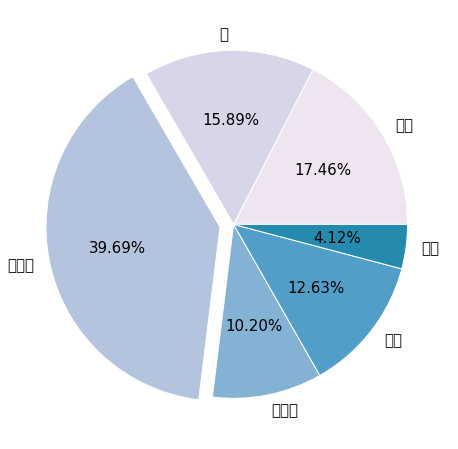

In [ ]:
# 제품군별 수주수량 합 시각화
plt.figure(figsize=(20,8))

x=['소스','밥','드레스','샐러드','마요','기타']
y=[1166802.4500000002,1061808.1,2651880.6500000004,681486.4450000001,843745.6,275118.22]
plt.pie(y, labels=x, labeldistance=1.09, autopct='%.2f%%', pctdistance=0.6, textprops= {'fontsize':15},
        colors=palette,wedgeprops={'ec':'w', 'lw':1},explode=[0,0,0.08,0,0,0])
plt.show()

# 샐러드가 가장 많다.

## 작업장별 제품군 수주수량 합 비율 시각화

In [ ]:
# 작업장별 제품군별 수주수량 합
product_booking_cooking_no_ideal_source_w = product_booking_cooking_no_ideal_source.groupby('작업장코드')['수주수량KG'].sum()
product_booking_cooking_no_ideal_bob_w = product_booking_cooking_no_ideal_bob.groupby('작업장코드')['수주수량KG'].sum()
product_booking_cooking_no_ideal_salad_w = product_booking_cooking_no_ideal_salad.groupby('작업장코드')['수주수량KG'].sum()
product_booking_cooking_no_ideal_mayo_w = product_booking_cooking_no_ideal_mayo.groupby('작업장코드')['수주수량KG'].sum()
product_booking_cooking_no_ideal_etc_w = product_booking_cooking_no_ideal_etc.groupby('작업장코드')['수주수량KG'].sum()
product_booking_cooking_no_ideal_dress_w = product_booking_cooking_no_ideal_dress.groupby('작업장코드')['수주수량KG'].sum()

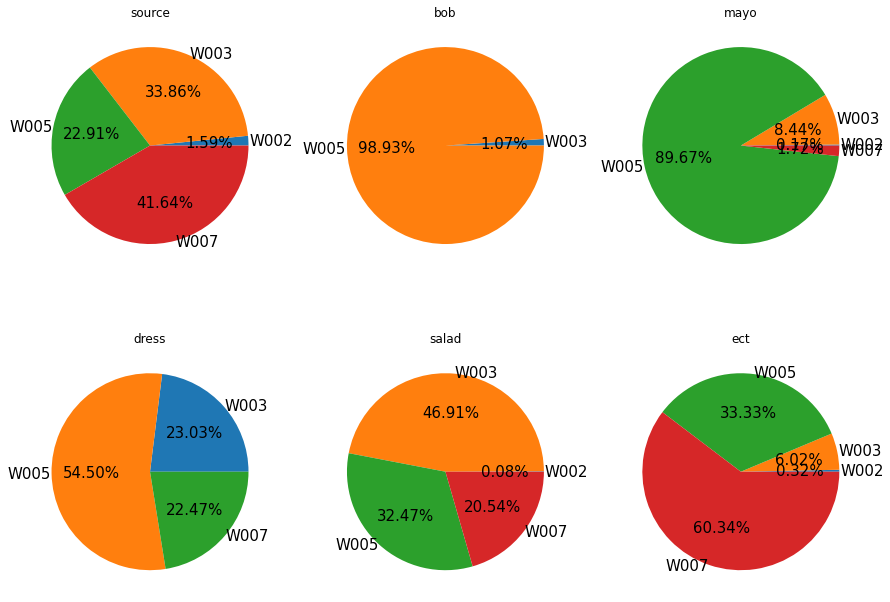

In [ ]:
# 제품군별 작업장 비율 파이차트

fig, ax = plt.subplots(2,3,figsize=(15,11))

ax[0][0].pie(product_booking_cooking_no_ideal_source_w, labels=product_booking_cooking_no_ideal_source_w.index, labeldistance=1.01, autopct='%.2f%%', pctdistance=0.6, textprops= {'fontsize':15})
ax[0][1].pie(product_booking_cooking_no_ideal_bob_w, labels=product_booking_cooking_no_ideal_bob_w.index, labeldistance=1.01, autopct='%.2f%%', pctdistance=0.6, textprops= {'fontsize':15})
ax[0][2].pie(product_booking_cooking_no_ideal_salad_w, labels=product_booking_cooking_no_ideal_salad_w.index, labeldistance=1.01, autopct='%.2f%%', pctdistance=0.6, textprops= {'fontsize':15})
ax[1][0].pie(product_booking_cooking_no_ideal_mayo_w, labels=product_booking_cooking_no_ideal_mayo_w.index, labeldistance=1.01, autopct='%.2f%%', pctdistance=0.6, textprops= {'fontsize':15})
ax[1][1].pie(product_booking_cooking_no_ideal_etc_w, labels=product_booking_cooking_no_ideal_etc_w.index, labeldistance=1.01, autopct='%.2f%%', pctdistance=0.6, textprops= {'fontsize':15})
ax[1][2].pie(product_booking_cooking_no_ideal_dress_w, labels=product_booking_cooking_no_ideal_dress_w.index, labeldistance=1.01, autopct='%.2f%%', pctdistance=0.6, textprops= {'fontsize':15})

ax[0][0].set_title('source')
ax[0][1].set_title('bob')
ax[0][2].set_title('mayo')
ax[1][0].set_title('dress')
ax[1][1].set_title('salad')
ax[1][2].set_title('ect')

plt.show()

## 제품군별 월단위 수주수량 그래프

In [ ]:
# 제품군별 연월별 수주수량 합
product_booking_cooking_no_ideal_source_day = product_booking_cooking_no_ideal_source.groupby('수주일자_년월').sum()
product_booking_cooking_no_ideal_bob_day = product_booking_cooking_no_ideal_bob.groupby('수주일자_년월').sum()
product_booking_cooking_no_ideal_dress_day = product_booking_cooking_no_ideal_dress.groupby('수주일자_년월').sum()
product_booking_cooking_no_ideal_mayo_day = product_booking_cooking_no_ideal_mayo.groupby('수주일자_년월').sum()
product_booking_cooking_no_ideal_salad_day = product_booking_cooking_no_ideal_salad.groupby('수주일자_년월').sum()
product_booking_cooking_no_ideal_etc_day = product_booking_cooking_no_ideal_etc.groupby('수주일자_년월').sum()

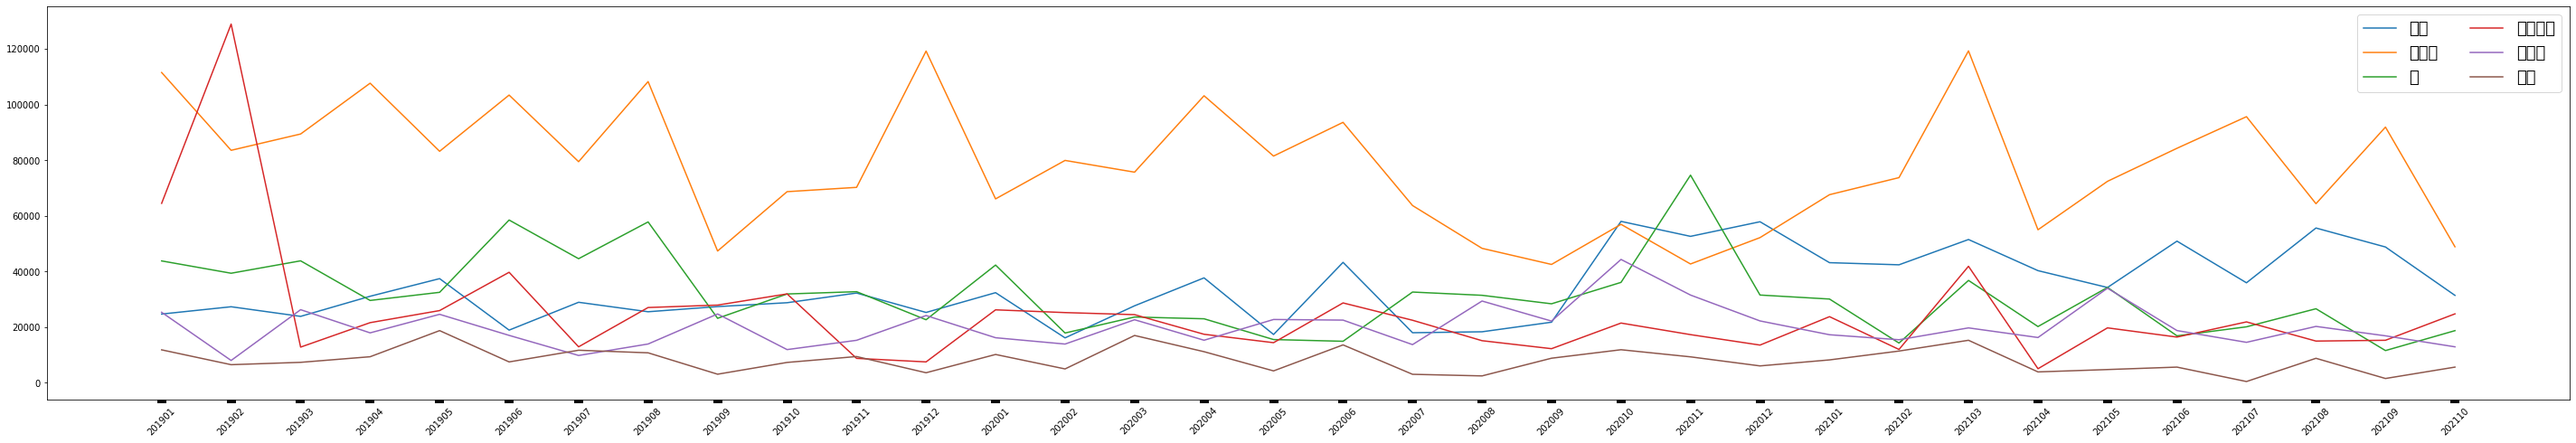

In [ ]:
plt.figure(figsize=(50,8))


x=product_booking_cooking_no_ideal_source_day.index
y=product_booking_cooking_no_ideal_source_day['수주수량KG']
plt.plot(x,y, label = '소스')

x=product_booking_cooking_no_ideal_salad_day.index
y=product_booking_cooking_no_ideal_salad_day['수주수량KG']
plt.plot(x,y,label = '샐러드')

x=product_booking_cooking_no_ideal_bob_day.index
y=product_booking_cooking_no_ideal_bob_day['수주수량KG']
plt.plot(x,y,label = '밥')

x=product_booking_cooking_no_ideal_mayo_day.index
y=product_booking_cooking_no_ideal_mayo_day['수주수량KG']
plt.plot(x,y, label = '마요네즈')

x=product_booking_cooking_no_ideal_dress_day.index
y=product_booking_cooking_no_ideal_dress_day['수주수량KG']
plt.plot(x,y, label = '드레싱')


x=product_booking_cooking_no_ideal_etc_day.index
y=product_booking_cooking_no_ideal_etc_day['수주수량KG']
plt.plot(x,y, label = '기타')

plt.legend(loc='top right',fontsize=18,ncol=2)
plt.tick_params(axis='x', width=10)
plt.xticks(rotation=45)
plt.show()

## 작업장별 출하여부 비율 시각화

In [ ]:
# 작업장별 출하여부로 서브셋 생성
product_booking_cooking_no_ideal_w5 = product_booking_cooking_no_ideal[product_booking_cooking_no_ideal['작업장코드']=='W005'].groupby('출하완료여부')['수주수량KG'].count()
product_booking_cooking_no_ideal_w7 = product_booking_cooking_no_ideal[product_booking_cooking_no_ideal['작업장코드']=='W007'].groupby('출하완료여부')['수주수량KG'].count()
product_booking_cooking_no_ideal_w3 = product_booking_cooking_no_ideal[product_booking_cooking_no_ideal['작업장코드']=='W003'].groupby('출하완료여부')['수주수량KG'].count()
product_booking_cooking_no_ideal_w2 = product_booking_cooking_no_ideal[product_booking_cooking_no_ideal['작업장코드']=='W002'].groupby('출하완료여부')['수주수량KG'].count()

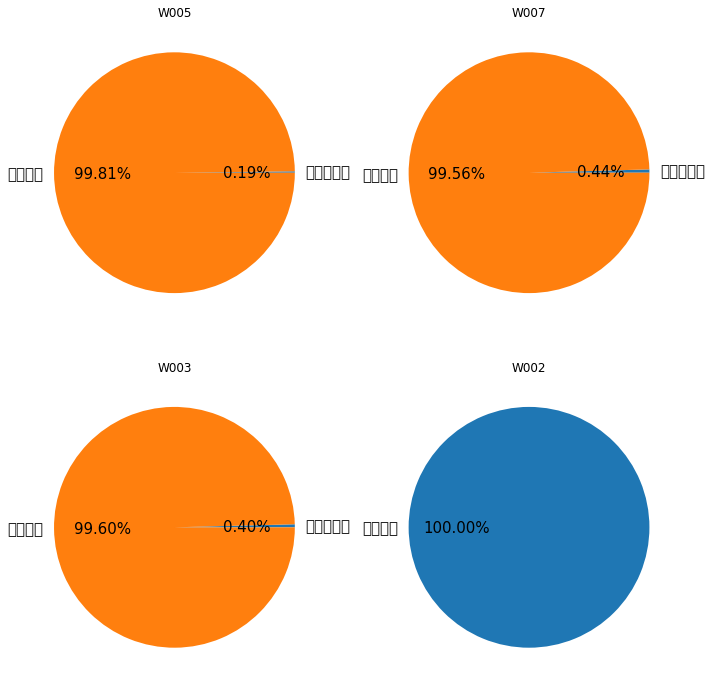

In [ ]:
# 제품군별 작업장 비율 파이차트

fig, ax = plt.subplots(2,2,figsize=(10,10))

x=['출하미완료','출하완료']
x1=['출하완료']
ax[0][0].pie(product_booking_cooking_no_ideal_w5, labels=x, labeldistance=1.09, autopct='%.2f%%', pctdistance=0.6, textprops= {'fontsize':15})
ax[0][1].pie(product_booking_cooking_no_ideal_w7, labels=x, labeldistance=1.09, autopct='%.2f%%', pctdistance=0.6, textprops= {'fontsize':15})
ax[1][0].pie(product_booking_cooking_no_ideal_w3, labels=x, labeldistance=1.09, autopct='%.2f%%', pctdistance=0.6, textprops= {'fontsize':15})
ax[1][1].pie(product_booking_cooking_no_ideal_w2, labels=x1, labeldistance=1.09, autopct='%.2f%%', pctdistance=0.6, textprops= {'fontsize':15})


ax[0][0].set_title('W005')
ax[0][1].set_title('W007')
ax[1][0].set_title('W003')
ax[1][1].set_title('W002')

plt.tight_layout()
plt.show()

## 전체 품목 연월별 출하여부 라인차트

In [ ]:
# 출하 여부로 나눠서 서브셋 생성
product_booking_cooking_no_ideal_n = product_booking_cooking_no_ideal[product_booking_cooking_no_ideal['출하완료여부']=='N']
product_booking_cooking_no_ideal_y = product_booking_cooking_no_ideal[product_booking_cooking_no_ideal['출하완료여부']=='Y']

In [ ]:
# 연월별 수주수량의평균 서브셋 생성
product_booking_cooking_no_ideal_y_day = product_booking_cooking_no_ideal_y.groupby('수주일자_년월').mean()
product_booking_cooking_no_ideal_n_day = product_booking_cooking_no_ideal_n.groupby('수주일자_년월').mean()

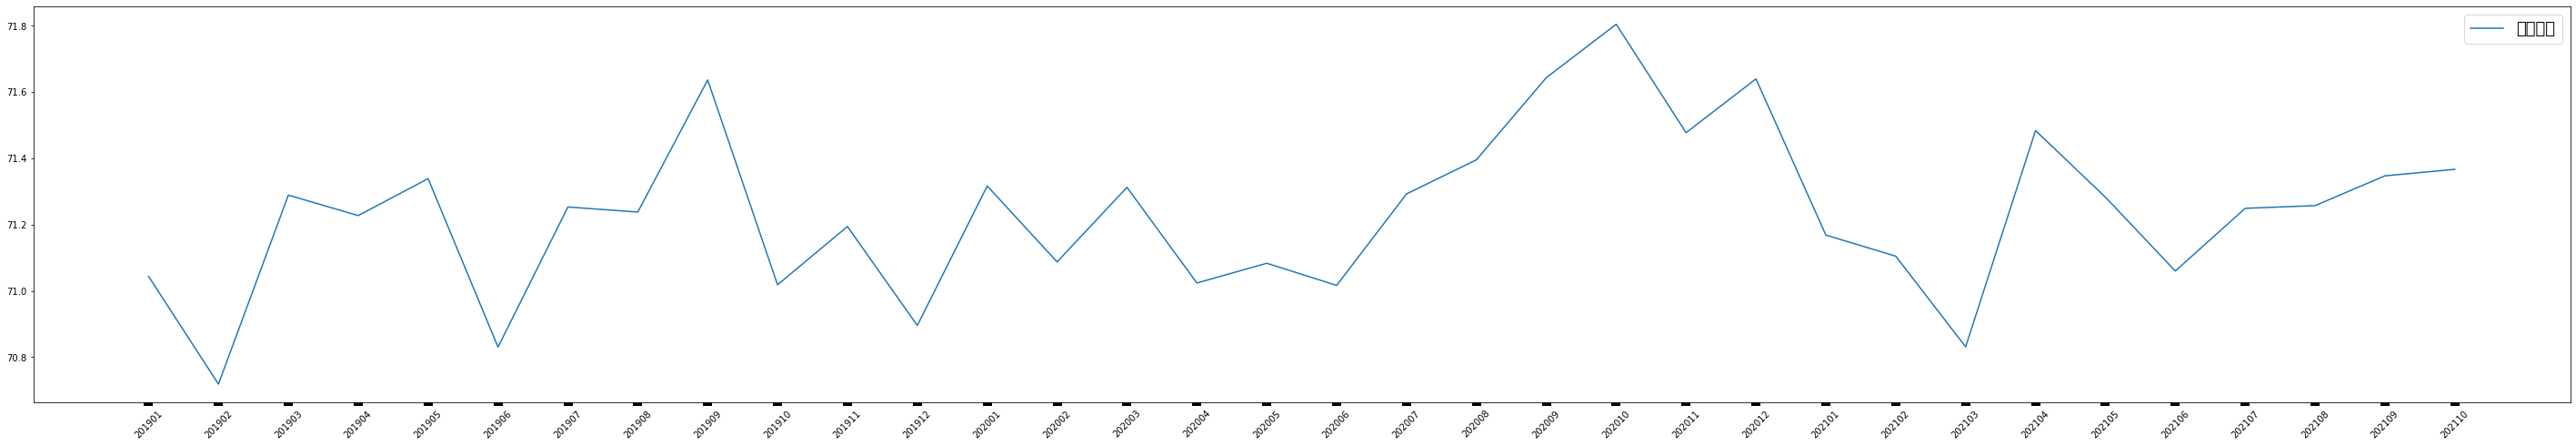

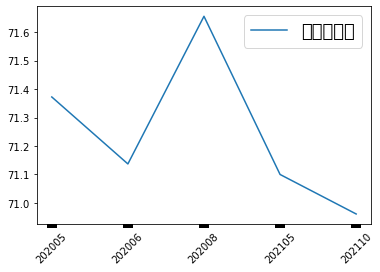

In [ ]:
plt.figure(figsize=(50,8))

x=product_booking_cooking_no_ideal_y_day.index
y=product_booking_cooking_no_ideal_y_day['수주수량KG']
plt.plot(x,y, label = '출하완료')

plt.legend(loc='top right',fontsize=18,ncol=2)
plt.tick_params(axis='x', width=10)
plt.xticks(rotation=45)
plt.show()

x=product_booking_cooking_no_ideal_n_day.index
y=product_booking_cooking_no_ideal_n_day['수주수량KG']
plt.plot(x,y, label = '출하미완료')

plt.legend(loc='top right',fontsize=18,ncol=2)
plt.tick_params(axis='x', width=10)
plt.xticks(rotation=45)
plt.show()

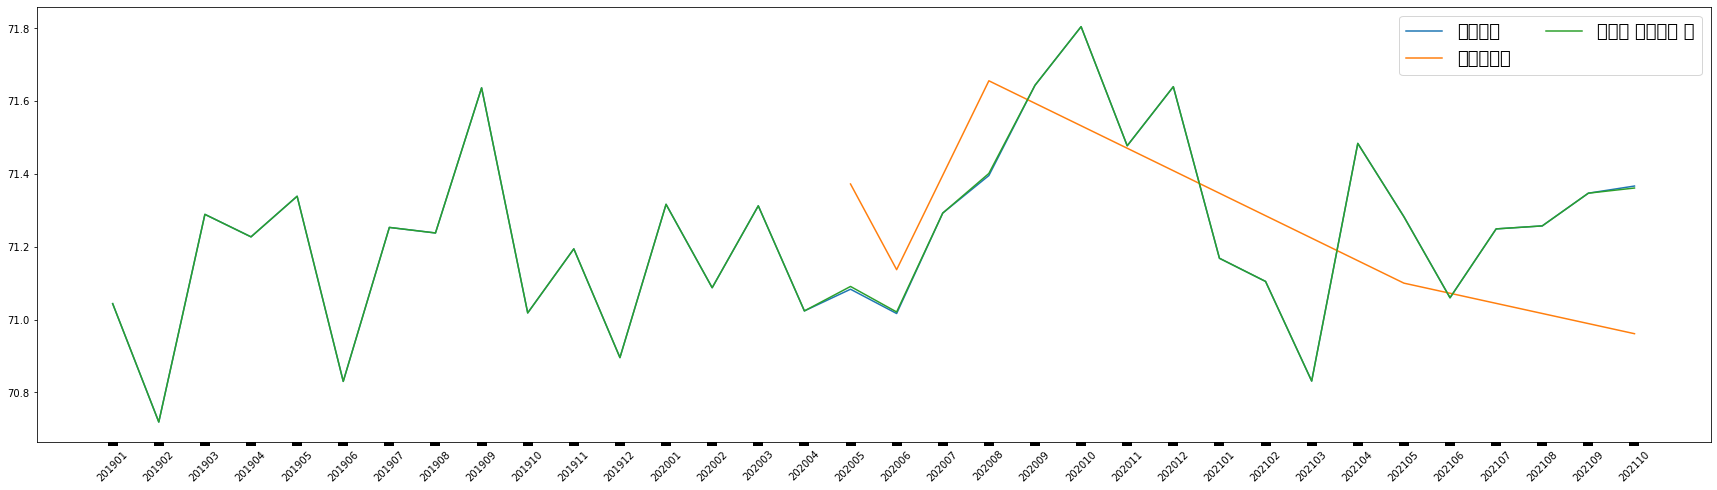

In [ ]:
# 전체 수주량과 한번에 그리기
product_booking_cooking_no_ideal_day = product_booking_cooking_no_ideal.groupby('수주일자_년월').mean()


plt.figure(figsize=(30,8))

x=product_booking_cooking_no_ideal_y_day.index
y=product_booking_cooking_no_ideal_y_day['수주수량KG']
plt.plot(x,y, label = '출하완료')


x=product_booking_cooking_no_ideal_n_day.index
y=product_booking_cooking_no_ideal_n_day['수주수량KG']
plt.plot(x,y, label = '출하미완료')

x=product_booking_cooking_no_ideal_day.index
y=product_booking_cooking_no_ideal_day['수주수량KG']
plt.plot(x,y, label = '연월별 수주수량 합')

plt.legend(loc='top right',fontsize=18,ncol=2)
plt.tick_params(axis='x', width=10)
plt.xticks(rotation=45)
plt.show()

## 작업장별 출하완료여부 비율 시각화

In [ ]:
#출하완료여부로 나눠진 서브셋 작업장별로 그룹바이
product_booking_cooking_no_ideal_y_work = product_booking_cooking_no_ideal_y.groupby('작업장코드').sum()
product_booking_cooking_no_ideal_n_work = product_booking_cooking_no_ideal_n.groupby('작업장코드').sum()

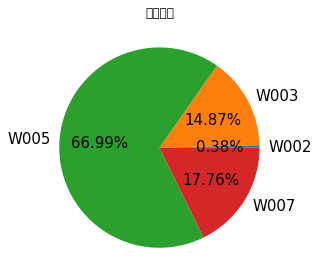

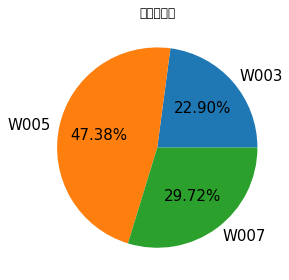

In [ ]:
# 시각화
x=product_booking_cooking_no_ideal_y_work.index
y=product_booking_cooking_no_ideal_y_work['수주수량KG']
plt.pie(y, labels=x, labeldistance=1.09, autopct='%.2f%%', pctdistance=0.6, textprops= {'fontsize':15})

plt.title('출하완료')
plt.tight_layout()
plt.show()

x=product_booking_cooking_no_ideal_n_work.index
y=product_booking_cooking_no_ideal_n_work['수주수량KG']
plt.pie(y, labels=x, labeldistance=1.09, autopct='%.2f%%', pctdistance=0.6, textprops= {'fontsize':15})


plt.title('출하미완료')

plt.tight_layout()
plt.show()
# WOO2작업장은 미완료된 제품이 없다.

## 생산일자 연월별 에러발생 횟수 시각화

In [ ]:
# 에러 데이터의 연월 컬럼 생성
error['생산일자_연월'] = error['생산일자'].astype('str')
error['생산일자_연월'] = error['생산일자_연월'].str.split('-').str[0]+error['생산일자_연월'].str.split('-').str[1]

In [ ]:
# 결측치 제거
error.dropna(inplace=True)
# 2019년 이후 데이터만 추출
error_day = error.groupby('생산일자_연월', as_index=False).count()
error_day['생산일자_연월'] = error_day['생산일자_연월'].astype('int')
error_day_drop = error_day[error_day['생산일자_연월']> 201900]
# 인덱스 문자열로 변환
error_day_drop['생산일자_연월'] = error_day_drop['생산일자_연월'].astype('str')

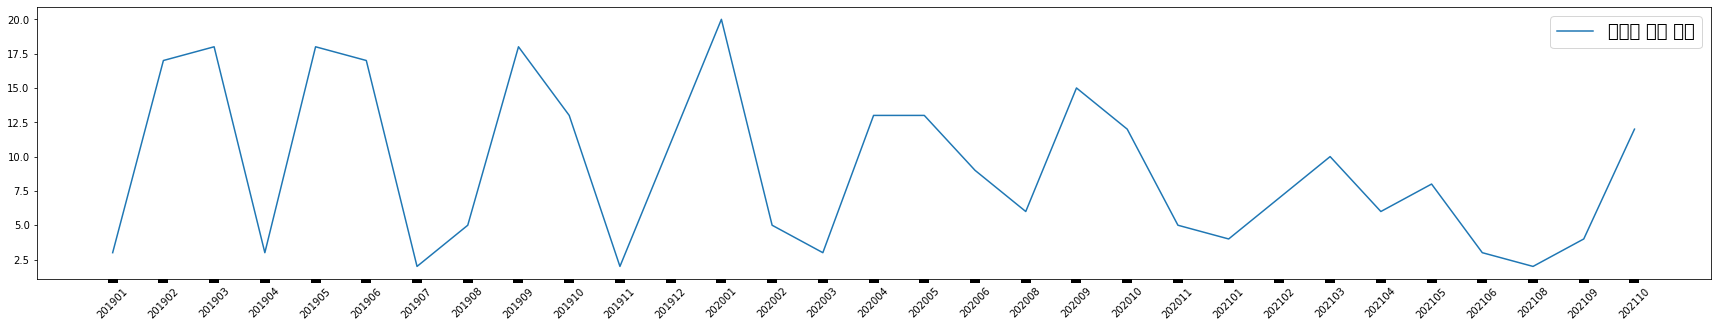

In [ ]:
plt.figure(figsize=(30,5))


x=error_day_drop['생산일자_연월']
y=error_day_drop['Error_Message']
plt.plot(x,y, label = '연월별 에러 횟수')

plt.legend(loc='upper right',fontsize=18,ncol=2)
plt.tick_params(axis='x', width=10)
plt.xticks(rotation=45)
plt.show()

## 제품군별 출하완료여부 비율 시각화

In [ ]:
# 제품군별 출하완료여부로 그룹바이한 서브셋 생성
product_booking_cooking_no_ideal_source_yn = product_booking_cooking_no_ideal_source.groupby('출하완료여부').count()
product_booking_cooking_no_ideal_bob_yn = product_booking_cooking_no_ideal_bob.groupby('출하완료여부').count()
product_booking_cooking_no_ideal_mayo_yn = product_booking_cooking_no_ideal_mayo.groupby('출하완료여부').count()
product_booking_cooking_no_ideal_dress_yn = product_booking_cooking_no_ideal_dress.groupby('출하완료여부').count()
product_booking_cooking_no_ideal_salad_yn = product_booking_cooking_no_ideal_salad.groupby('출하완료여부').count()
product_booking_cooking_no_ideal_etc_yn = product_booking_cooking_no_ideal_etc.groupby('출하완료여부').count()

Text(0.5, 1.0, 'etc')

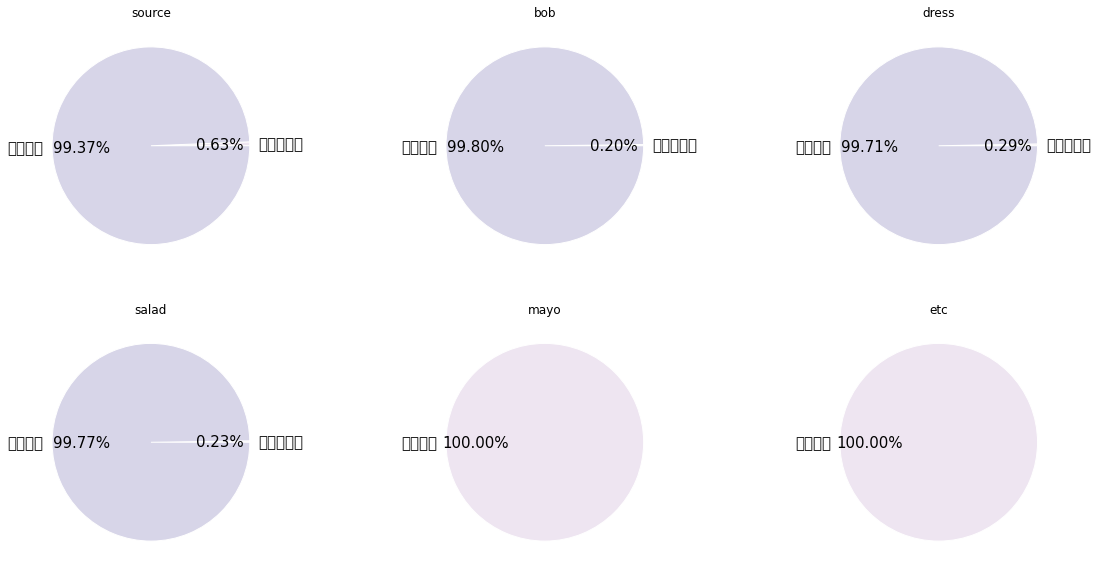

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(20,10))
x=['출하미완료','출하완료']
y=product_booking_cooking_no_ideal_source_yn['품목명']
ax[0][0].pie(y, labels=x, labeldistance=1.09, autopct='%.2f%%', pctdistance=0.7, textprops= {'fontsize':15},
             colors=palette,wedgeprops={'ec':'w', 'lw':1})

y=product_booking_cooking_no_ideal_bob_yn['품목명']
ax[0][1].pie(y, labels=x, labeldistance=1.09, autopct='%.2f%%', pctdistance=0.7, textprops= {'fontsize':15},
             colors=palette,wedgeprops={'ec':'w', 'lw':1})

y=product_booking_cooking_no_ideal_dress_yn['품목명']
ax[0][2].pie(y, labels=x, labeldistance=1.09, autopct='%.2f%%', pctdistance=0.7, textprops= {'fontsize':15},
             colors=palette,wedgeprops={'ec':'w', 'lw':1})

y=product_booking_cooking_no_ideal_salad_yn['품목명']
ax[1][0].pie(y, labels=x, labeldistance=1.09, autopct='%.2f%%', pctdistance=0.7, textprops= {'fontsize':15},
             colors=palette,wedgeprops={'ec':'w', 'lw':1})

x=['출하완료']
y=product_booking_cooking_no_ideal_mayo_yn['품목명']
ax[1][1].pie(y, labels=x, labeldistance=1.09, autopct='%.2f%%', pctdistance=0.7, textprops= {'fontsize':15},
             colors=palette,wedgeprops={'ec':'w', 'lw':1})

y=product_booking_cooking_no_ideal_etc_yn['품목명']
ax[1][2].pie(y, labels=x, labeldistance=1.09, autopct='%.2f%%', pctdistance=0.7, textprops= {'fontsize':15},
             colors=palette,wedgeprops={'ec':'w', 'lw':1})


ax[0][0].set_title('source')
ax[0][1].set_title('bob')
ax[0][2].set_title('dress')
ax[1][0].set_title('salad')
ax[1][1].set_title('mayo')
ax[1][2].set_title('etc')

# 모델링

## 모델링 전처리
* 새 컬럼에 전날 수주수량을 채운 데이터프레임 만들기

In [ ]:
# 특정 품목 서브셋 생성
subset = product_booking_cooking_no_ideal[product_booking_cooking_no_ideal['품목코드_통일'] == '16A01063']

In [ ]:
# 일자와 수량 서브셋 생성
subset_plot=pd.DataFrame()
subset_plot=subset[['수주일자_년월일','수주수량KG','생산시간']]
subset_plot

,수주일자_년월일,수주수량KG,생산시간
2947658,2020-05-26,72.0,78.41
2947659,2020-05-26,72.0,74.69
2947660,2020-05-26,72.0,78.71
2947661,2020-05-26,72.0,75.12
2947662,2020-05-26,72.0,73.11
...,...,...,...
3585521,2021-10-20,70.0,NaN
3585522,2021-10-20,70.0,74.11
3585523,2021-10-20,70.0,72.17
3585524,2021-10-20,70.0,72.99


In [ ]:
# 수주일자 날짜별로 수주수량 정렬
subset_plot_sort_kg = subset_plot.groupby('수주일자_년월일')[['수주수량KG']].sum().sort_values(by=['수주일자_년월일'])
subset_plot_sort_kg

,수주수량KG
수주일자_년월일,
2019-01-03,3920.0
2019-01-06,7840.0
2019-01-13,3920.0
2019-01-14,4032.0
2019-01-16,3864.0
...,...
2021-10-08,3920.0
2021-10-13,4144.0
2021-10-15,7840.0


In [ ]:
subset_plot_sort_kg.tail(10)

,수주수량KG
수주일자_년월일,
2021-09-09,3920.0
2021-09-13,3920.0
2021-09-17,3920.0
2021-09-29,3920.0
2021-10-01,3920.0
2021-10-08,3920.0
2021-10-13,4144.0
2021-10-15,7840.0
2021-10-19,3920.0


In [ ]:
# 전날 수량값으로 채운 데이터프레임 만들기
def model(x):
    subset_plot_sort_test_model = subset_plot_sort_kg.tail(x) 
    for i in range(x):
        df_shifted = subset_plot_sort_kg.shift(i+1)
        df_shifted = df_shifted.dropna()
        day = df_shifted.tail(x).values
        subset_plot_sort_test_model[f'day{i+1}'] =day
        subset_plot_sort_test_model= subset_plot_sort_test_model.iloc[:,:3].copy()
    return subset_plot_sort_test_model

In [ ]:
subset_plot_sort_test_model= model(5)
subset_plot_sort_test_model

,수주수량KG,day1,day2
수주일자_년월일,,,
2021-10-08,3920.0,3920.0,3920.0
2021-10-13,4144.0,3920.0,3920.0
2021-10-15,7840.0,4144.0,3920.0
2021-10-19,3920.0,7840.0,4144.0
2021-10-20,11760.0,3920.0,7840.0


## 모델링

In [ ]:
import numpy as np
from scipy import stats  #  과학용 계산 라이브러리
from sklearn.datasets import load_boston  #  사이킷런 데이타셋
from sklearn.model_selection import train_test_split 
# 트레인/테스트 데이터 나누기
from sklearn.linear_model import LinearRegression #  모델 학습
from sklearn.metrics import mean_squared_error #  에러 계산
import warnings
warnings.filterwarnings('ignore') # 경고무시

In [ ]:
# 인풋, 타겟 설정
x=subset_plot_sort_test_model.drop(['수주수량KG'], axis=1) # input
y=subset_plot_sort_test_model['수주수량KG'] # target

In [ ]:
# 트레인/ 테스트 구분
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

In [ ]:
# 정규화
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)

In [ ]:
# 학습
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(max_depth=10)
clf.fit(x_train_sc, y_train)

RandomForestRegressor(max_depth=10)

In [ ]:
# # 분류형일시 예측
# y_predict = clf.predict(x_test_sc)
# accuracy_score(y_test,y_predict)

In [ ]:
# train 정확도
clf.score(x_train, y_train)

-0.9317296008869176

In [ ]:
# test 정확도
clf.score(x_test, y_test)
# 실패,.,.

nan

## 출고일자와 수주일자의 차이로 시도

In [ ]:
# 출고일자와 수주일자의 차이
product_booking_cooking_no_ideal['출고_수주'] = product_booking_cooking_no_ideal['출고수량KG'] - product_booking_cooking_no_ideal['수주수량KG']

In [ ]:
product_booking_cooking_no_ideal.corr()

,출고수량KG,수주수량KG,충전실온도,실링온도,쿠킹온도,쿠킹스팀압력,실링압력,생산시간,출하완료여부_num,출고_수주
출고수량KG,1.000000,0.076967,0.011859,0.001498,0.001175,-0.009956,-0.000346,0.011702,-0.001210,0.998843
수주수량KG,0.076967,1.000000,0.069311,-0.025389,-0.023493,0.057989,0.024014,0.036987,-0.002361,0.028930
충전실온도,0.011859,0.069311,1.000000,-0.044198,-0.033699,0.324282,0.298452,0.110597,0.003573,0.008546
실링온도,0.001498,-0.025389,-0.044198,1.000000,0.999481,0.018169,-0.074034,0.011586,0.005681,0.002726
쿠킹온도,0.001175,-0.023493,-0.033699,0.999481,1.000000,0.050378,-0.053436,0.018851,0.005755,0.002311
쿠킹스팀압력,-0.009956,0.057989,0.324282,0.018169,0.050378,1.000000,0.636585,0.257054,0.002502,-0.012779
실링압력,-0.000346,0.024014,0.298452,-0.074034,-0.053436,0.636585,1.000000,0.101830,0.003313,-0.001505
생산시간,0.011702,0.036987,0.110597,0.011586,0.018851,0.257054,0.101830,1.000000,-0.003331,0.009952
출하완료여부_num,-0.001210,-0.002361,0.003573,0.005681,0.005755,0.002502,0.003313,-0.003331,1.000000,-0.001099
출고_수주,0.998843,0.028930,0.008546,0.002726,0.002311,-0.012779,-0.001505,0.009952,-0.001099,1.000000


In [ ]:
x=product_booking_cooking_no_ideal['출고_수주'] # input
y=product_booking_cooking_no_ideal['출고수량KG'] # target

In [ ]:
# 정규화
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)
# 학습
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(max_depth=10)
clf.fit(x_train_sc, y_train)

RandomForestRegressor(max_depth=10)

In [ ]:
# train 정확도
clf.score(x_train, y_train)
# 실패

-0.7601488082039909

# 다른 시도

## 전처리(서브셋 생성)

In [ ]:
# 단위에도 널값 존재
booking['수주단위'].unique()

array(['EA', 'kg', nan], dtype=object)

In [ ]:
# 수주수량 문자열로 형변환
booking['수주수량_str'] = booking['수주수량'].astype('str')

In [ ]:
# 단위 kg이고 수주수량 0 인 데이터 서브셋 생성
booking_kg_new = booking[ (booking['수주단위'] == 'kg') & (booking['수주수량_str'] == '0.0') ]

In [ ]:
# 확인
booking_kg_new['수주수량_str'].unique()

array(['0.0'], dtype=object)

In [ ]:
# 단위가 EA인 데이터
booking_ea_new = booking[ (booking['수주단위'] == 'EA')  ]

In [ ]:
# 그중에 수량이 0이 아닌 서브셋 생성
booking_ea_new  = booking_ea_new[ ~ (booking_ea_new['수주수량_str'] == '0.0')  ]

In [ ]:
# 확인
booking_ea_new[booking_ea_new['수주수량_str'] == '0.0']

,수주사업장,수주일자,수주일련번호,거래처코드,수주부서,수주품목코드,수주단위,출고수량KG,수주수량KG,수주단가,수주금액,부가세금액,출하완료여부,납기일자,기준단가,생산지시,수주수량,수주수량_str


## 전처리(출하완료여부 수치화, 반품인 경우 나누기)

In [ ]:
# 출하완료여부 수치화
booking_ea_new['출하완료여부_num'] = booking_ea_new['출하완료여부'].apply(lambda x: replace_num(x))
booking_kg_new['출하완료여부_num'] = booking_kg_new['출하완료여부'].apply(lambda x: replace_num(x))

In [ ]:
# 출고수량이0이고 출하가 완료된 데이터의 인덱스 추출
index1 = booking_ea_new[(booking_ea_new['출고수량KG']==0.0) & (booking_ea_new['출하완료여부_num']==1)].index
index2 = booking_kg_new[(booking_kg_new['출고수량KG']==0.0) & (booking_kg_new['출하완료여부_num']==1)].index

In [ ]:
index1

Int64Index([], dtype='int64')

In [ ]:
# 해당 인덱스 2(반품)으로 변경
booking_ea_new.loc[index1,'출하완료여부_num']=2
booking_kg_new.loc[index2,'출하완료여부_num']=2

In [ ]:
# 확인
print(booking_ea_new['출하완료여부_num'].unique())
print(booking_kg_new['출하완료여부_num'].unique())

# 성공한 모델링

## booking 전처리

In [ ]:
booking['수주수량'] = booking['수주수량'].astype({'수주수량':'int'})
booking
# 수주수량을 int로 만들어줌 
# '수주수량'을 이용해 '수주단위' EA와 kg을 나눌 수 있음

# **중요한 부분 
# '수주수량'의 값이 없으면 kg
# '수주수량'의 값이 있으면 EA

# '수주수량'의 값과 '수주수량kg' 값이 같다면 kg
# '수주수량'의 값과 '수주수량kg' 값이 같지 않다면 EA

# '수주단위'가 NaN일 경우 '수주수량'과 '수주수량kg'의 값을 비교 후 채워 넣을 수 있다.

,수주사업장,수주일자,수주일련번호,거래처코드,수주부서,수주품목코드,수주단위,출고수량KG,수주수량KG,수주단가,수주금액,부가세금액,출하완료여부,납기일자,기준단가,생산지시,수주수량,수주수량_str
0,60.0,20151214,436,SI0275,sc600,1BA03008,EA,1.5,1.5,0.00,0.0,0,Y,20151215,0.0,N,5,5.0
1,60.0,20151214,437,SI0275,sc600,1BA03059,EA,0.9,0.9,0.00,0.0,0,Y,20151215,0.0,N,3,3.0
2,60.0,20151214,438,SI0275,sc600,1BA03058,EA,0.9,0.9,0.00,0.0,0,Y,20151215,0.0,N,3,3.0
3,60.0,20151214,441,SI0298,sc600,16A01039,EA,5.0,5.0,3630.00,16500.0,1650,Y,20151215,3630.0,N,5,5.0
4,60.0,20151214,443,SI0298,sc600,16D01021,kg,100.0,100.0,5400.00,540000.0,0,Y,20151215,5400.0,N,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757233,60.0,20211102,152,SI0275,sc600,13R10064,EA,0.0,12.0,0.00,0.0,0,N,20211103,0.0,N,6,6.0
1757234,1.0,20211104,1,IA1406,400,13A00748,kg,0.0,200.0,9800.00,1960000.0,196000,N,20211105,9800.0,NaN,0,0.0
1757235,1.0,20211104,2,IA1406,400,18A03045,kg,0.0,30.0,8400.00,252000.0,25200,N,20211105,8400.0,NaN,0,0.0
1757236,20.0,20211030,113,IJ9780,400,16A03015,EA,0.0,1.0,4405.76,4406.0,0,Y,20211031,4410.0,N,1,1.0


In [ ]:
booking_set = booking.drop(['수주사업장','수주일자','수주일련번호','거래처코드','수주부서','수주품목코드','수주단가','수주금액','부가세금액','납기일자','기준단가', '생산지시'], axis=1)
booking_set
# 필요없는 컬럼삭제

,수주단위,출고수량KG,수주수량KG,출하완료여부,수주수량,수주수량_str
0,EA,1.5,1.5,Y,5,5.0
1,EA,0.9,0.9,Y,3,3.0
2,EA,0.9,0.9,Y,3,3.0
3,EA,5.0,5.0,Y,5,5.0
4,kg,100.0,100.0,Y,0,0.0
...,...,...,...,...,...,...
1757233,EA,0.0,12.0,N,6,6.0
1757234,kg,0.0,200.0,N,0,0.0
1757235,kg,0.0,30.0,N,0,0.0
1757236,EA,0.0,1.0,Y,1,1.0


In [ ]:
booking_set['출하완료여부'] = booking_set['출하완료여부'].apply(lambda x : 1 if x == 'Y' else 0)

# '출하완료여부' Y = 1 , N = 0 으로 바꾸기

In [ ]:
for i, row in booking_set.iterrows():
  if booking_set.at[i, '수주수량'] ==booking_set.at[i, '수주수량KG']:
    booking_set.at[i, '차이'] = 2

booking_set

# '수주수량'과 '수주수량kg'를 비교 후 '차이' 컬럼을 생성 후 2라는 숫자로 표시 해줄 것 
#  '수주수량'과 '수주수량kg'이 같으면 '차이' 컬럼에 2가 들어감
#  '수주수량'과 '수주수량kg'이 다르면 '차이' 컬럼에 null값이 들어감

In [ ]:
booking_set.isnull().sum()

## '수주단위' 14810의 NaN값을 채워줄 예정
# '차이'의 NaN의 개수는 수주단위에 EA가 들어갈 개수라고 보면 됌

수주단위          14810
출고수량KG            0
수주수량KG            0
출하완료여부            0
수주수량              0
수주수량_str          0
차이          1665538
dtype: int64

In [ ]:
booking_pure_kg = booking_set[booking_set['차이'] == 2 ]
booking_pure_kg
# 순수 kg
# 단위를 kg으로 바꿔줘야한다

,수주단위,출고수량KG,수주수량KG,출하완료여부,수주수량,수주수량_str,차이
3,EA,5.0,5.0,1,5,5.0,2.0
55,EA,220.0,220.0,1,220,220.0,2.0
127,EA,200.0,200.0,1,200,200.0,2.0
129,EA,10.0,10.0,1,10,10.0,2.0
183,EA,30.0,30.0,1,30,30.0,2.0
...,...,...,...,...,...,...,...
1757211,EA,0.0,40.0,0,40,40.0,2.0
1757212,EA,0.0,10.0,0,10,10.0,2.0
1757217,EA,0.0,20.0,0,20,20.0,2.0
1757218,EA,0.0,20.0,0,20,20.0,2.0


In [ ]:
booking_pure_kg['수주단위'] = 'kg'
booking_pure_kg

,수주단위,출고수량KG,수주수량KG,출하완료여부,수주수량,수주수량_str,차이
3,kg,5.0,5.0,1,5,5.0,2.0
55,kg,220.0,220.0,1,220,220.0,2.0
127,kg,200.0,200.0,1,200,200.0,2.0
129,kg,10.0,10.0,1,10,10.0,2.0
183,kg,30.0,30.0,1,30,30.0,2.0
...,...,...,...,...,...,...,...
1757211,kg,0.0,40.0,0,40,40.0,2.0
1757212,kg,0.0,10.0,0,10,10.0,2.0
1757217,kg,0.0,20.0,0,20,20.0,2.0
1757218,kg,0.0,20.0,0,20,20.0,2.0


In [ ]:
booking_pure_EA = booking_set[~(booking_set['차이'] == 2) ]
booking_pure_EA
# 순수 EA
# 단위를 EA으로 바꿔줘야한다

,수주단위,출고수량KG,수주수량KG,출하완료여부,수주수량,수주수량_str,차이
0,EA,1.5,1.5,1,5,5.0,NaN
1,EA,0.9,0.9,1,3,3.0,NaN
2,EA,0.9,0.9,1,3,3.0,NaN
4,kg,100.0,100.0,1,0,0.0,NaN
5,EA,921.6,921.6,1,120,120.0,NaN
...,...,...,...,...,...,...,...
1757232,EA,0.0,256.0,0,80,80.0,NaN
1757233,EA,0.0,12.0,0,6,6.0,NaN
1757234,kg,0.0,200.0,0,0,0.0,NaN
1757235,kg,0.0,30.0,0,0,0.0,NaN


In [ ]:
booking_pure_EA['수주단위'] = 'EA'
booking_pure_EA

,수주단위,출고수량KG,수주수량KG,출하완료여부,수주수량,수주수량_str,차이
0,EA,1.5,1.5,1,5,5.0,NaN
1,EA,0.9,0.9,1,3,3.0,NaN
2,EA,0.9,0.9,1,3,3.0,NaN
4,EA,100.0,100.0,1,0,0.0,NaN
5,EA,921.6,921.6,1,120,120.0,NaN
...,...,...,...,...,...,...,...
1757232,EA,0.0,256.0,0,80,80.0,NaN
1757233,EA,0.0,12.0,0,6,6.0,NaN
1757234,EA,0.0,200.0,0,0,0.0,NaN
1757235,EA,0.0,30.0,0,0,0.0,NaN


## 출하완료 세분화

In [ ]:
booking_pure_EA = booking_pure_EA.drop(['수주단위', '차이'], axis =1)
# 모델 만들기 전 쓸모없는 컬럼 삭제

In [ ]:
booking_pure_kg = booking_pure_kg.drop(['수주단위', '차이'], axis =1)
# 모델 만들기 전 쓸모없는 컬럼 삭제

In [ ]:
# booking_pure_EA에서 출고수량이 0 인데 출하완료된 데이터들의 인덱스 추출
index1 = booking_pure_EA[(booking_pure_EA['출고수량KG']==0.0) & (booking_pure_EA['출하완료여부']==1)].index
# 반품(2)으로 변경
booking_pure_EA.loc[index1,'출하완료여부']=2

In [ ]:
# booking_pure_kg 출고수량이 0 인데 출하완료된 데이터들의 인덱스 추출
index2 = booking_pure_kg[(booking_pure_kg['출고수량KG']==0.0) & (booking_pure_kg['출하완료여부']==1)].index
# 반품(2)으로 변경
booking_pure_kg.loc[index2,'출하완료여부']=2

In [ ]:
# 확인
booking_pure_EA['출하완료여부'].unique()

array([1, 2, 0])

In [ ]:
# 확인
booking_pure_kg['출하완료여부'].unique()

array([1, 2, 0])

## 모델링

### booking_pure_EA 모델링

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
x = booking_pure_EA.drop(['출하완료여부','수주수량'],axis=1)
y = booking_pure_EA['출하완료여부']

In [ ]:
x_tn, x_te, y_tn, y_te = train_test_split(x,y, test_size=0.9, random_state=0) # 학습시킬 데이터, 테스트용 데이터 설정


# 스케일링 하는 곳
std_scale = StandardScaler()
std_scale.fit(x_tn)
x_tn_std = std_scale.transform(x_tn)
x_te_std = std_scale.transform(x_te)

# 모델생성 randomforest로 만들어줌
clf_rf = RandomForestClassifier(max_depth=3, random_state=0)
clf_rf.fit(x_tn_std,y_tn)

RandomForestClassifier(max_depth=3, random_state=0)

In [ ]:
# 예측값 class에 들어가는 예측값을 넣는다.
pred_rf = clf_rf.predict(x_te_std)
print(pred_rf)

[1 1 1 ... 1 1 1]


In [ ]:
# 정확도 검사
accuracy = accuracy_score(y_te, pred_rf)
print(accuracy)

0.9963902240516083


In [ ]:
# 학습데이터를 얼마나 잘 학습했는지 나타내는 정도
clf_rf.score(x_tn_std,y_tn)

0.996241436659802

### booking_pure_kg 모델링

In [ ]:
x = booking_pure_kg.drop(['출하완료여부','수주수량'],axis=1)
y = booking_pure_kg['출하완료여부']

In [ ]:
x_tn, x_te, y_tn, y_te = train_test_split(x,y, test_size=0.9, random_state=0) # 학습시킬 데이터, 테스트용 데이터 설정


# 스케일링 하는 곳
std_scale = StandardScaler()
std_scale.fit(x_tn)
x_tn_std = std_scale.transform(x_tn)
x_te_std = std_scale.transform(x_te)

# 모델생성 randomforest로 만들어줌
clf_rf = RandomForestClassifier(max_depth=3, random_state=0)
clf_rf.fit(x_tn_std,y_tn)

RandomForestClassifier(max_depth=3, random_state=0)

In [ ]:
# 예측값 class에 들어가는 예측값을 넣는다.
pred_rf = clf_rf.predict(x_te_std)
print(pred_rf)

[1 2 1 ... 1 1 1]


In [ ]:
# 정확도 검사
accuracy = accuracy_score(y_te, pred_rf)
print(accuracy)

0.9937598449048831


In [ ]:
# 학습데이터를 얼마나 잘 학습했는지 나타내는 정도
clf_rf.score(x_tn_std,y_tn)

0.9943293347873501